In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy.api as sc
# import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests

import sys
sys.path.insert(1, '../')
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

/home/jz286/myenv/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.11.0


In [2]:
# GLOBAL VARIABLES
DATA_PATH = '/n/groups/price/martin/tms_gene_data'
DGE_RES_PATH = DATA_PATH + '/DGE_result'
DGE_RES_PATH_OLD = DATA_PATH + '/DE_result_old'
ANNO_DATA_PATH = DATA_PATH + '/annotation_data'
OUTPUT_PATH_FIG = DATA_PATH + '/result_v1/tms_gene_figure'
OUTPUT_PATH_TAB = DATA_PATH + '/result_v1/tms_gene_table'
OUTPUT_PATH_TEMP = DATA_PATH + '/result_v1/temp_result'

METHOD_LIST = ['facs', 'droplet']
DIC_METHOD_NAME = {'facs':'FACS', 'droplet':'Droplet'}

### Load data

In [3]:
# Load the data obs df: facs
temp_data = util.load_normalized_data(DATA_PATH, data_name='facs', 
                                      flag_size_factor=False, flag_log1p=False)
gene_list_facs = list(temp_data.var_names)
gene_list_facs.sort()
df_obs_facs = temp_data.obs.copy()
df_obs_facs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_facs['tissue'],
                                                       df_obs_facs['cell_ontology_class'])]

# Load the data obs df: droplet
temp_data = util.load_normalized_data(DATA_PATH, data_name='droplet',
                                      flag_size_factor=False, flag_log1p=False)
gene_list_droplet = list(temp_data.var_names)
gene_list_droplet.sort()
df_obs_droplet = temp_data.obs.copy()
df_obs_droplet['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_droplet['tissue'], 
                                                          df_obs_droplet['cell_ontology_class'])]
# dic for obs
dic_obs = {'facs':df_obs_facs, 'droplet':df_obs_droplet}
dic_gene_list = {'facs':gene_list_facs, 'droplet':gene_list_droplet}

# common gene_list
gene_list_common = list(set(gene_list_facs) & set(gene_list_droplet))
gene_list_common.sort()

# del temp results
del temp_data

Trying to set attribute `.obs` of view, copying.


### Load DGE results

In [4]:
# Load DGE results
df_info_facs,dic_dge_facs = util.load_DGE_res(DATA_PATH, dname='facs.tc')
df_info_droplet,dic_dge_droplet = util.load_DGE_res(DATA_PATH, dname='droplet.tc')

# Change analyte name
temp_list = list(dic_dge_facs.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_facs['%s.%s'%(tissue,cell_type)] = dic_dge_facs[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte: del dic_dge_facs[analyte]

temp_list = list(dic_dge_droplet.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_droplet['%s.%s'%(tissue,cell_type)] = dic_dge_droplet[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte:  del dic_dge_droplet[analyte]
        
# fixit: update bh_p (not sure if this is necessary)
dic_dge = {'facs':dic_dge_facs, 'droplet':dic_dge_droplet}

In [5]:
# dic_analysis_list
# dic_fdr_threshold

# analysis list: facs
min_cell_number = 100
# min_cell_number = 50
ind_select = (df_info_facs['n_cell_young']>min_cell_number) & (df_info_facs['n_cell_old']>min_cell_number)
analysis_list_facs = list(df_info_facs.index[ind_select])

# analysis list: droplet
min_cell_number = 500
# min_cell_number = 200
ind_select = (df_info_droplet['n_cell_young']>min_cell_number) & (df_info_droplet['n_cell_old']>min_cell_number)
analysis_list_droplet = list(df_info_droplet.index[ind_select])
analysis_list_droplet.remove('Spleen.B cell')

dic_analysis_list = {'facs':analysis_list_facs, 'droplet':analysis_list_droplet}
for method in METHOD_LIST:
    print('%s, n_tc=%d'%(method, len(dic_analysis_list[method])))

# thresholds parameters
coef_threshold = 0.005
dic_fdr_threshold = {x:0.01 for x in METHOD_LIST}

facs, n_tc=76
droplet, n_tc=25


In [6]:
# Structured DGE results
dic_H_p = {}
dic_H_fdr = {}
dic_coef = {}
dic_coef_z = {}
dic_coef_se = {}
dic_coef_p = {}
dic_coef_fdr = {}

for method in METHOD_LIST:
    
    dic_H_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_H_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_z[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_se[method] = pd.DataFrame(index = dic_gene_list[method])
    
    dic_coef_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    
    for analyte in dic_analysis_list[method]:
        
        dic_H_p[method][analyte] = dic_dge[method][analyte]['age.H_p']
        dic_H_fdr[method][analyte] = dic_dge[method][analyte]['age.H_fdr']
        dic_coef[method][analyte] = dic_dge[method][analyte]['age.logFC']
        dic_coef_z[method][analyte] = dic_dge[method][analyte]['age.logFC_z']
        dic_coef_se[method][analyte] = dic_dge[method][analyte]['age.logFC']/\
                                        dic_dge[method][analyte]['age.logFC_z']
        
        temp_v = dic_dge[method][analyte]['age.logFC_z']
        temp_gene_list = list(dic_dge[method][analyte].index)
        temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
        temp_v_p[np.isnan(temp_v_p)] = 1
        temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]
        
        dic_coef_p[method].loc[temp_gene_list, analyte] = temp_v_p
        dic_coef_fdr[method].loc[temp_gene_list, analyte] = temp_v_fdr
        
    # na values
    dic_H_p[method] = dic_H_p[method].fillna(1)
    dic_H_fdr[method] = dic_H_fdr[method].fillna(1)
    dic_coef[method] = dic_coef[method].fillna(0)    
    dic_coef_z[method] = dic_coef_z[method].fillna(0)    
    dic_coef_se[method] = dic_coef_se[method].fillna(1e6)
    
    dic_coef_p[method] = dic_coef_p[method].fillna(1)
    dic_coef_fdr[method] = dic_coef_fdr[method].fillna(1)

/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [7]:
# # Write file for mashr 
# output_folder = DATA_PATH + '/DGE_result/mashr_result'
# for method in METHOD_LIST:
#     dic_coef[method].to_csv(output_folder + '/coef.%s_tc.csv'%method, sep=',')
#     dic_coef_se[method].to_csv(output_folder + '/coef_se.%s_tc.csv'%method, sep=',')
#     dic_coef_fdr[method].to_csv(output_folder + '/coef_fdr.%s_tc.csv'%method, sep=',')

In [8]:
# # Structured mashr results
# dic_mashr_lfsr = {}
# dic_mashr_pm = {}
# dic_mashr_psd = {}

# for method in METHOD_LIST:
    
#     dic_mashr_lfsr[method] = pd.read_csv(DGE_RES_PATH+'/mashr_result/mashr_lfsr.%s_tc.csv'%method,
#                                          index_col=0)
#     dic_mashr_pm[method] = pd.read_csv(DGE_RES_PATH+'/mashr_result/mashr_pm.%s_tc.csv'%method,
#                                        index_col=0)
#     dic_mashr_psd[method] = pd.read_csv(DGE_RES_PATH+'/mashr_result/mashr_psd.%s_tc.csv'%method,
#                                        index_col=0)

### Load annotations

In [9]:
# facs cell category
df_cell_category = pd.read_csv(ANNO_DATA_PATH + '/cell_ontology_class_functional_annotations.csv',
                               header=0, index_col=None)
df_cell_category = df_cell_category.fillna('')

# Add analyte
df_cell_category['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_cell_category['tissue'],
                                                            df_cell_category['cell_ontology_class'])]
df_cell_category.index = df_cell_category['analyte']

# Update functional annotation
ind_select = (df_cell_category['functional_annotations (correction by Martin)']!='')
df_cell_category.loc[ind_select, 'functional_annotations'] = \
    df_cell_category.loc[ind_select, 'functional_annotations (correction by Martin)']

df_cell_category['cell category'] = ['%s;%s'%(x,y) if y!='' else x
                                     for x,y in zip(df_cell_category['functional_annotations'],
                                                      df_cell_category['secondary_functional_annotations'])]

df_cell_category = df_cell_category[['cell category', 'turnover rate in mouse', 
                                     'turnover rate in human']]

In [10]:
# annotation
dic_anno = {x:pd.DataFrame(index=dic_analysis_list[x])
            for x in METHOD_LIST}

for method in METHOD_LIST:
    # tissue and cell_ontology_class
    dic_anno[method]['tissue'] = [x.split('.')[0] for x in dic_anno[method].index]
    dic_anno[method]['cell_ontology_class'] = [x.split('.')[1] for x in dic_anno[method].index]
    
    # n_cell
    dic_anno[method]['n_cell'] = [((dic_obs[method]['tissue']==x.split('.')[0]) & 
                                   (dic_obs[method]['cell_ontology_class']==x.split('.')[1])).sum() 
                                  for x in dic_anno[method].index]
    
    # n_celltype in the tissue
    temp_dic = {x:(dic_anno[method]['tissue']==x).sum() for x in set(dic_anno[method]['tissue'])}
    dic_anno[method]['n_celltype'] = [temp_dic[x] for x in dic_anno[method]['tissue']]
    
    # n_rej
    dic_anno[method]['n_rej'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                        (np.absolute(dic_coef[method][x])>coef_threshold))
                                 for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.up'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                           (dic_coef[method][x]>coef_threshold))
                                    for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.down'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                             (dic_coef[method][x]<-coef_threshold))
                                      for x in dic_anno[method].index]
    
    
    dic_anno[method] = dic_anno[method].join(df_cell_category)

In [11]:
# gene annotation (global aging results)
dic_gene_anno = {}
for method in METHOD_LIST:

    dic_gene_anno[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_gene_anno[method]['prop_sig'] = ((dic_H_fdr[method]<dic_fdr_threshold[method]) & 
                                         (np.absolute(dic_coef[method])>coef_threshold)).mean(axis=1)
    dic_gene_anno[method]['prop_upreg'] = (dic_coef[method]>coef_threshold).sum(axis=1) /\
                                            (np.absolute(dic_coef[method])>coef_threshold).sum(axis=1) 
#     dic_gene_anno[method]['prop_upreg'] = (dic_mashr_pm[method]>coef_threshold).sum(axis=1) /\
#                                             (np.absolute(dic_mashr_pm[method])>coef_threshold).sum(axis=1) 
    
#     dic_gene_anno[method]['prop_upreg'] = (dic_coef[method]>1.96*dic_coef_se[method]).sum(axis=1) /\
#                                             (np.absolute(dic_coef[method])>1.96*dic_coef_se[method]).sum(axis=1) 
    dic_gene_anno[method]['median_fc'] = dic_coef[method].median(axis=1)
    dic_gene_anno[method]['median_fdr'] = dic_coef[method].median(axis=1)
    
    # weighted version 
    v_w = 1 / dic_anno[method].loc[dic_H_fdr[method].columns, 'n_celltype'].values
    v_w = v_w / v_w.mean()
    
    temp_v = ((dic_H_fdr[method]<dic_fdr_threshold[method]) & (np.absolute(dic_coef[method])>coef_threshold))
    dic_gene_anno[method]['prop_sig_w'] = np.average(temp_v, axis=1, weights=v_w)
    
    temp_v1 = np.average(dic_coef[method]>coef_threshold, axis=1, weights=v_w)
    temp_v2 = np.average(np.absolute(dic_coef[method])>coef_threshold, axis=1, weights=v_w)
    dic_gene_anno[method]['prop_upreg_w'] = temp_v1/temp_v2.clip(min=1e-3)
    
    # add global aging gene label 
    dic_gene_anno[method]['global'] = dic_gene_anno[method]['prop_sig']>0.5
    
    dic_gene_anno[method]['global.dir'] = ''
    ind_select = (dic_gene_anno[method]['global']) & (dic_gene_anno[method]['prop_upreg']>0.8)
    dic_gene_anno[method].loc[ind_select, 'global.dir'] = 'up'
    ind_select = (dic_gene_anno[method]['global']) & (dic_gene_anno[method]['prop_upreg']<0.2)
    dic_gene_anno[method].loc[ind_select, 'global.dir'] = 'down'
    ind_select = (dic_gene_anno[method]['global']) & (dic_gene_anno[method]['global.dir']=='')
    dic_gene_anno[method].loc[ind_select, 'global.dir'] = 'other'
    
    print('%s, Total:%d, Up:%d, Down:%d, Other:%d'%(method, dic_gene_anno[method]['global'].sum(),
                                                    (dic_gene_anno[method]['global.dir']=='up').sum(),
                                                    (dic_gene_anno[method]['global.dir']=='down').sum(),
                                                    (dic_gene_anno[method]['global.dir']=='other').sum()))

facs, Total:290, Up:93, Down:168, Other:29
droplet, Total:93, Up:12, Down:7, Other:74


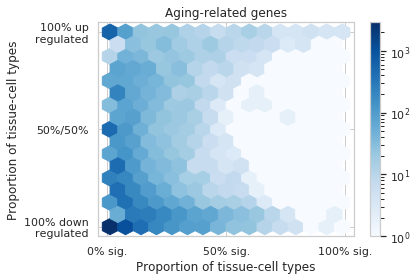

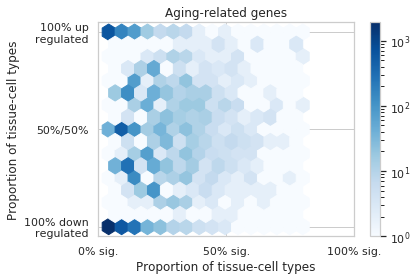

In [12]:
for method in METHOD_LIST:
    ind_select = dic_gene_anno[method]['prop_sig']>0
    df_plot = dic_gene_anno[method].loc[ind_select]

    plt.figure(figsize=[6,4])

    plt.hexbin(df_plot['prop_sig'], df_plot['prop_upreg'], gridsize=15,
               cmap = 'Blues', bins='log')    
    plt.colorbar()

    plt.ylabel('Proportion of tissue-cell types')
    plt.xlabel('Proportion of tissue-cell types')

    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    plt.title('Aging-related genes')
    plt.tight_layout()
    plt.show()


### Sharing 

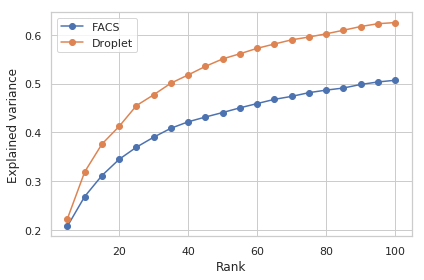

In [13]:
# NMF result
NMF_PATH = DATA_PATH+'/nmf_result'
method='facs'
rank_list = list(np.arange(5,101,5))
df_plot=pd.DataFrame(index=rank_list, columns=['evar.facs', 'evar.droplet'], data=0)
for method in METHOD_LIST:
    for n_rank in rank_list:
        temp_df = pd.read_csv(NMF_PATH+'/%s_rank_%d_cell_20000.summary'%(method,n_rank),
                              sep='\t', header=None, index_col=0)
        df_plot.loc[n_rank, 'evar.%s'%method] = float(temp_df.loc['evar', 1])
plt.figure()
for method in METHOD_LIST:
    plt.plot(rank_list, df_plot['evar.%s'%method], marker='o', label=DIC_METHOD_NAME[method])
plt.legend()
plt.ylabel('Explained variance')
plt.xlabel('Rank')
plt.tight_layout()
plt.savefig(OUTPUT_PATH_FIG+'/nmf_evar.pdf')
plt.show()

In [14]:
# NMF-based sharing 
dic_sharing = {}
for method in METHOD_LIST:
    
    n_comp=40
    
    df_nmf_basis = pd.read_csv(NMF_PATH+'/%s_rank_%d_cell_20000.nmf_basis'%(method,n_comp),
                               sep=',', header=0, index_col=0)
    mat_X = df_nmf_basis.values.copy()
    v_norm = (mat_X**2).sum(axis=0)
    mat_X = mat_X/np.sqrt(v_norm)
    mat_y = dic_coef[method].loc[df_nmf_basis.index].values
#     mat_y = mat_y - mat_y.mean(axis=0)
    mat_y = (mat_y.T - mat_y.mean(axis=1)).T

    # Projection by OLS 
    n_regressand = mat_y.shape[0]
    mat_xtx = np.dot(mat_X.T, mat_X)/n_regressand
    mat_xty = np.dot(mat_X.T, mat_y)/n_regressand
    mat_X_proj = np.linalg.solve(mat_xtx, mat_xty).T
    
    mat_res = mat_y - mat_X.dot(mat_X_proj.T)
    print('# Variance explained: %0.5g'
          %(1 - (mat_res**2).sum()/(mat_y**2).sum()))
    
    # Record the results 
    dic_sharing['nmf.%s'%method] = {}
    dic_sharing['nmf.%s'%method]['n_comp'] = n_comp
    dic_sharing['nmf.%s'%method]['v_gene'] = df_nmf_basis.index.values.copy()
    dic_sharing['nmf.%s'%method]['mat_basis'] = mat_X
    dic_sharing['nmf.%s'%method]['mat_X_proj'] = mat_X_proj
    dic_sharing['nmf.%s'%method]['cond_list'] = list(dic_coef[method].columns)
    
#     break

# Variance explained: 0.20584
# Variance explained: 0.28426


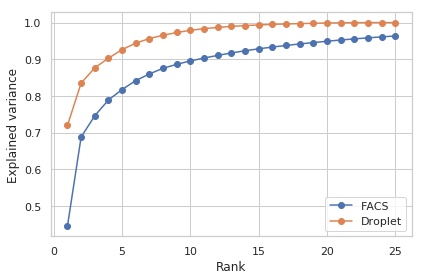

In [15]:
# SVD-based sharing 
plt.figure()
for method in METHOD_LIST:
    
    ind_select = ((dic_H_fdr[method]<dic_fdr_threshold[method]) &
               (dic_coef[method]>coef_threshold)).sum(axis=1)>0
    gene_list_svd = np.array(dic_H_fdr[method].index[ind_select])
    mat_X = dic_coef[method].loc[ind_select].values.copy().T

    # SVD
    n_comp = 10
    mat_X = mat_X - mat_X.mean(axis=0)
    mat_U,v_S,mat_Vh = sp.linalg.svd(mat_X, full_matrices=False)
    
    ind_sort = np.argsort(v_S**2)[::-1]
    mat_V = mat_Vh.T
    mat_U,v_S,mat_V = mat_U[:, ind_sort], v_S[ind_sort], mat_V[:, ind_sort]
    # flipping
    for i in np.arange(mat_V.shape[1]):
        if mat_U[:,i].sum()<0:
            mat_U[:,i],mat_V[:,i] = -mat_U[:,i], -mat_V[:,i]
    mat_X_proj = mat_X.dot(mat_V)[:, 0:n_comp]
        
    # Record the results 
    dic_sharing['svd.%s'%method] = {}
    dic_sharing['svd.%s'%method]['n_comp'] = n_comp
    dic_sharing['svd.%s'%method]['v_gene'] = gene_list_svd
    dic_sharing['svd.%s'%method]['mat_basis'] = mat_V[:, 0:n_comp]
    dic_sharing['svd.%s'%method]['mat_X_proj'] = mat_X_proj
    dic_sharing['svd.%s'%method]['cond_list'] = list(dic_coef[method].columns)
    
    # Explained variance
    var_total = (v_S**4).sum()
    v_evar = np.array([(v_S[0:x+1]**4).sum()/var_total for x in np.arange(25)])
    plt.plot(np.arange(1, 26), v_evar, marker='o', label=DIC_METHOD_NAME[method])    
    
#     break
plt.legend()
plt.ylabel('Explained variance')
plt.xlabel('Rank')
plt.tight_layout()
plt.savefig(OUTPUT_PATH_FIG+'/pca_evar.pdf')
plt.show()

In [16]:
# Sharing matrix
for method in METHOD_LIST:
    for opt in ['nmf', 'svd']:
        
        mat_X_proj = dic_sharing['%s.%s'%(opt,method)]['mat_X_proj'].copy()
        cond_list = dic_sharing['%s.%s'%(opt,method)]['cond_list'].copy()

        temp_y = sp.spatial.distance.pdist(mat_X_proj, metric='cosine')
        df_sharing = pd.DataFrame(index=cond_list, columns=cond_list,
                                  data = 1 - sp.spatial.distance.squareform(temp_y))
        temp_linkage = sp.cluster.hierarchy.linkage(temp_y, method='average')
        
        dic_sharing['%s.%s'%(opt,method)]['df_sharing'] = df_sharing.copy()
        dic_sharing['%s.%s'%(opt,method)]['linkage'] = temp_linkage.copy()

/tc_sharing.nmf_facs.pdf


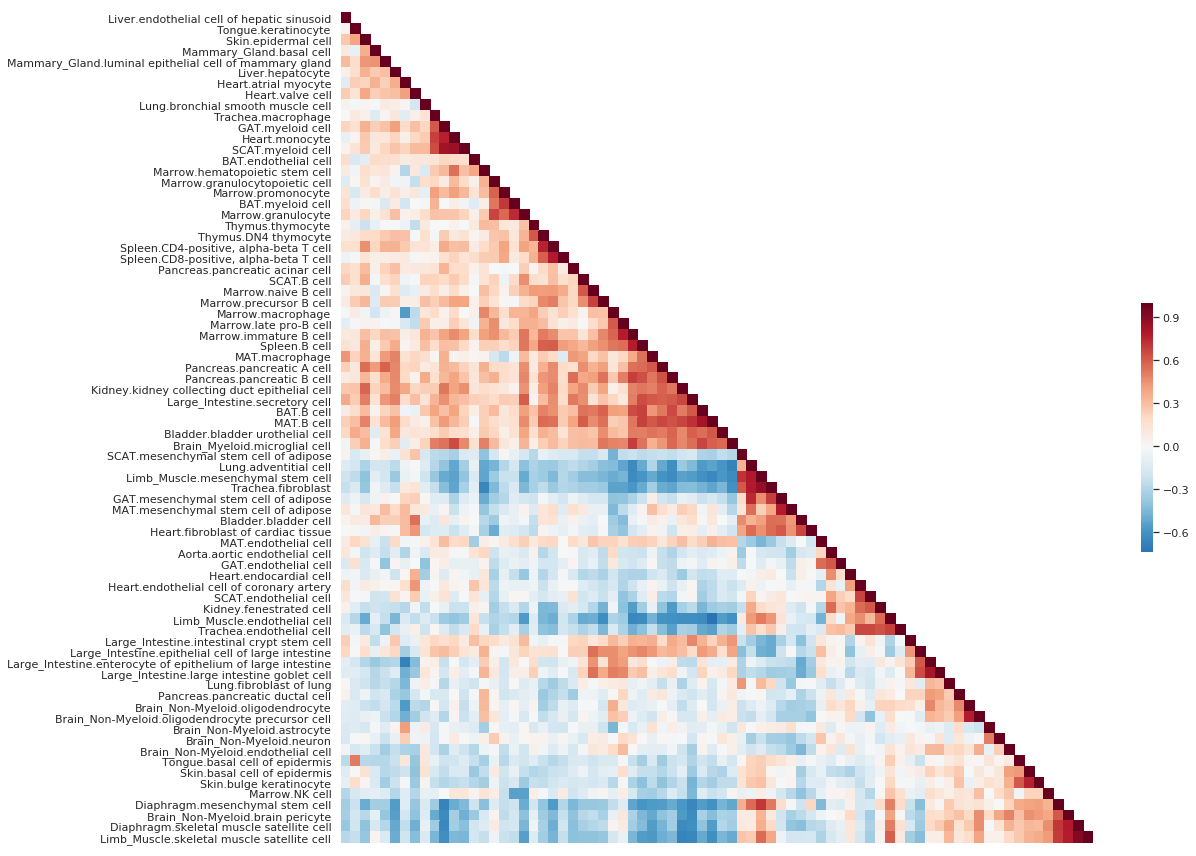

/tc_sharing.svd_facs.pdf


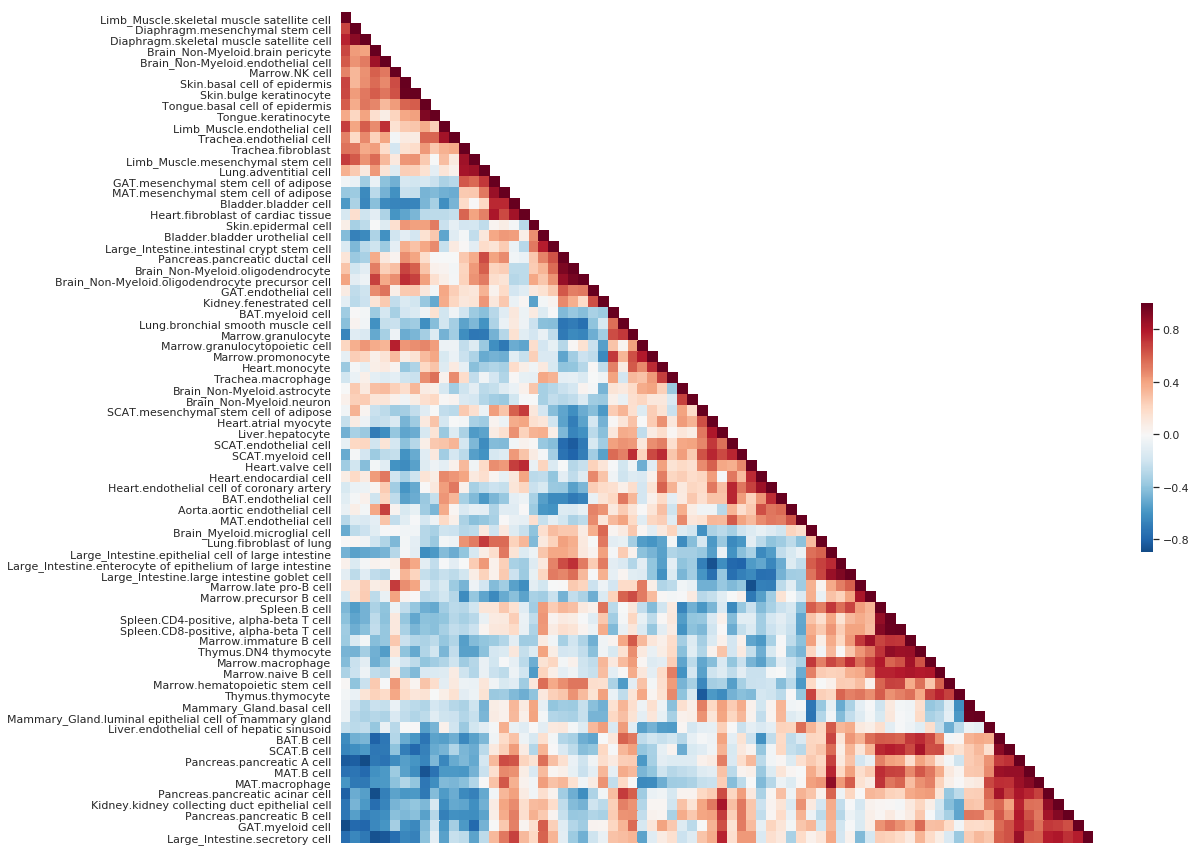

/tc_sharing.nmf_droplet.pdf


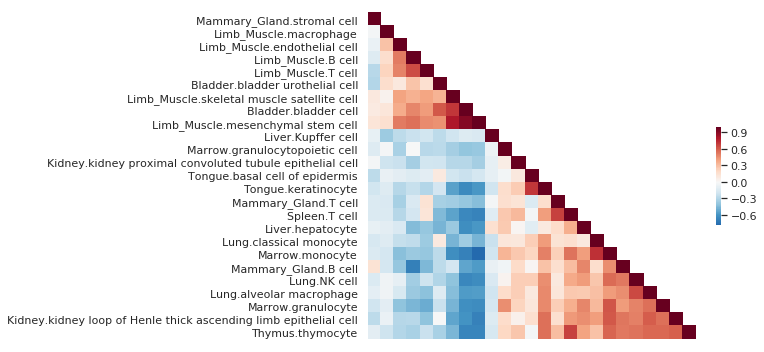

/tc_sharing.svd_droplet.pdf


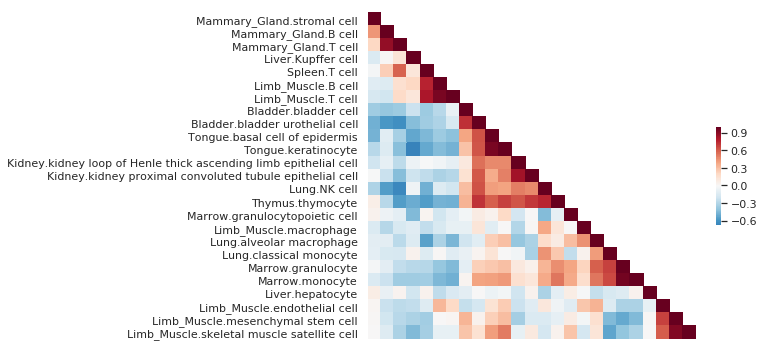

In [17]:
# Plot tissue-cell similarity
for method in METHOD_LIST:
# for method in ['droplet']:
    for opt in ['nmf', 'svd']:
        
        print('/tc_sharing.%s_%s.pdf'%(opt,method))

        df_plot = dic_sharing['%s.%s'%(opt,method)]['df_sharing'].copy()
        temp_linkage = dic_sharing['%s.%s'%(opt,method)]['linkage'].copy()

        ind_sort = list(df_plot.columns[sp.cluster.hierarchy.leaves_list(temp_linkage)])
        df_plot = df_plot.loc[ind_sort, ind_sort]
        temp_mat = df_plot.values
        temp_mask = np.triu(np.ones_like(temp_mat, dtype=np.bool), k=1)
        
        if method=='facs':
            plt.figure(figsize=[18,12])
        else:
            plt.figure(figsize=[11,5])
        sns.heatmap(df_plot, mask=temp_mask, xticklabels=False, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.3})
        plt.tight_layout()

        plt.savefig(OUTPUT_PATH_FIG+'/tc_sharing.%s_%s.pdf'%(opt,method))
        plt.show()
#     break

/tc_sharing.nmf_facs.pdf


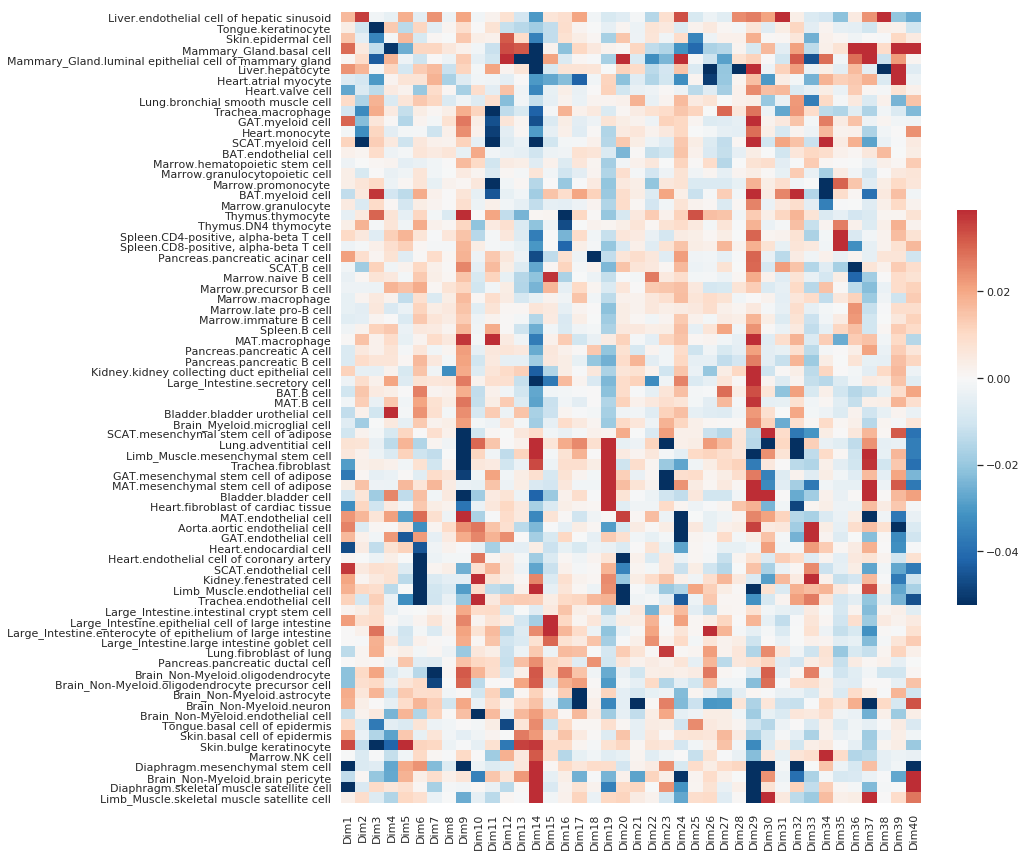

/tc_sharing.svd_facs.pdf


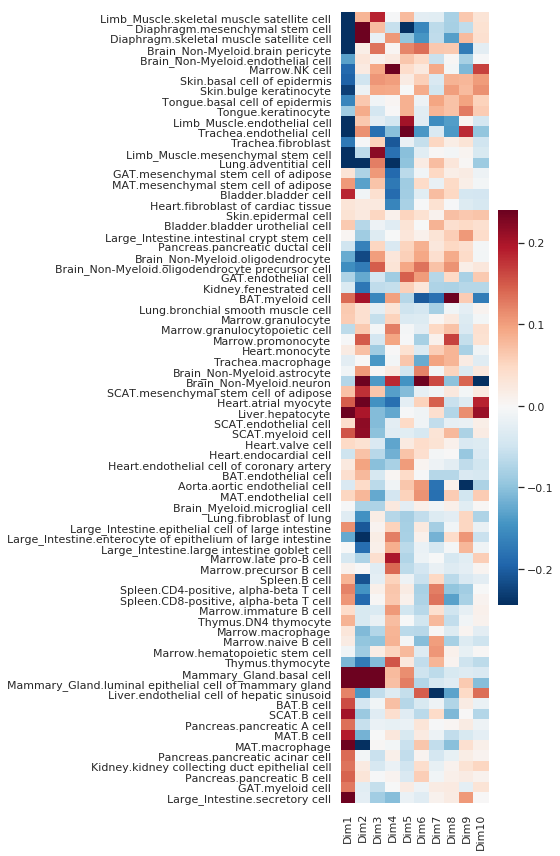

/tc_sharing.nmf_droplet.pdf


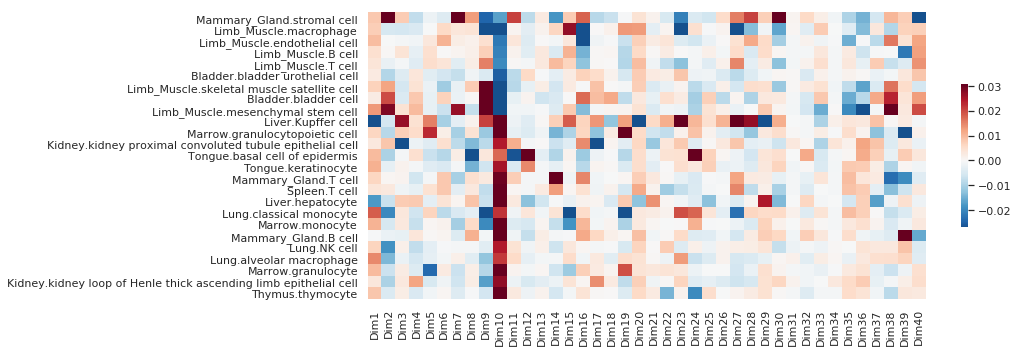

/tc_sharing.svd_droplet.pdf


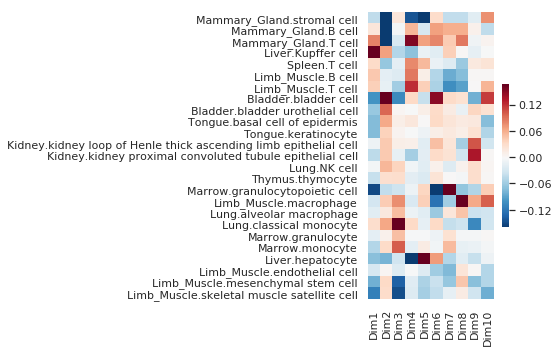

In [18]:
for method in METHOD_LIST:
    for opt in ['nmf', 'svd']:
        
        print('/tc_sharing.%s_%s.pdf'%(opt,method))
        
        mat_X_proj = dic_sharing['%s.%s'%(opt,method)]['mat_X_proj'].copy()
        temp_linkage = dic_sharing['%s.%s'%(opt,method)]['linkage'].copy()
        cond_list = dic_sharing['%s.%s'%(opt,method)]['cond_list'].copy()
        n_comp = dic_sharing['%s.%s'%(opt,method)]['n_comp']
        
        df_plot = pd.DataFrame(index=cond_list, columns=['Dim%d'%x for x in np.arange(1,n_comp+1)],
                               data = mat_X_proj.copy())
        
        ind_sort = list(df_plot.index[sp.cluster.hierarchy.leaves_list(temp_linkage)])
        df_plot = df_plot.loc[ind_sort]

        if method=='facs':
            plt.figure(figsize=[5+n_comp*0.25,12])
        else:
            plt.figure(figsize=[5+n_comp*0.25,5])
            
        sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5},
                    vmin=np.quantile(df_plot.values, 0.02),
                    vmax=np.quantile(df_plot.values, 0.98))
        plt.xticks(np.arange(df_plot.shape[1])+0.5, list(df_plot.columns), rotation=90)
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH_FIG+'/tc_sharing_proj.%s_%s.pdf'%(opt,method))
        plt.show()

In [19]:
# gene for each loading 
for method in METHOD_LIST:
    for opt in ['nmf', 'svd']:
        
        print('/tc_sharing.%s_%s.pdf'%(opt,method))
        
        n_comp = dic_sharing['%s.%s'%(opt,method)]['n_comp']
        mat_basis = dic_sharing['%s.%s'%(opt,method)]['mat_basis'].copy()
        v_gene = dic_sharing['%s.%s'%(opt,method)]['v_gene'].copy()
        
        dic_pathway = {}
        for i_comp in np.arange(n_comp):
            
            if opt=='svd':
                ind_select = np.absolute(mat_basis[:,i_comp])>0.02
            else:
                ind_select = np.absolute(mat_basis[:,i_comp])>0.005

#             temp_v = np.absolute(mat_basis[:,i_comp])
#             ind_select = np.argsort(temp_v)[-500:]
            
            temp_gene_list = v_gene[ind_select]
            temp_gene_list = list(temp_gene_list)
            
            print('Dim%d\tn_gene=%d'%(i_comp,len(temp_gene_list)))

            gp = GProfiler(return_dataframe=True)
            temp_df = gp.profile(organism='mmusculus', query=temp_gene_list,
                                       sources=['GO:BP'],
                                       significance_threshold_method='fdr', 
                                       user_threshold=0.01, 
                                       background=dic_gene_list['facs'])

            dic_pathway[i_comp] = temp_df.copy()
            
        dic_sharing['%s.%s'%(opt,method)]['dic_pathway'] = dic_pathway.copy()

/tc_sharing.nmf_facs.pdf
Dim0	n_gene=455
Dim1	n_gene=395
Dim2	n_gene=496
Dim3	n_gene=438
Dim4	n_gene=377
Dim5	n_gene=353
Dim6	n_gene=333
Dim7	n_gene=369
Dim8	n_gene=443
Dim9	n_gene=425
Dim10	n_gene=556
Dim11	n_gene=437
Dim12	n_gene=383
Dim13	n_gene=286
Dim14	n_gene=474
Dim15	n_gene=499
Dim16	n_gene=683
Dim17	n_gene=260
Dim18	n_gene=323
Dim19	n_gene=386
Dim20	n_gene=607
Dim21	n_gene=459
Dim22	n_gene=441
Dim23	n_gene=617
Dim24	n_gene=395
Dim25	n_gene=549
Dim26	n_gene=490
Dim27	n_gene=299
Dim28	n_gene=382
Dim29	n_gene=394
Dim30	n_gene=354
Dim31	n_gene=497
Dim32	n_gene=362
Dim33	n_gene=297
Dim34	n_gene=396
Dim35	n_gene=318
Dim36	n_gene=488
Dim37	n_gene=306
Dim38	n_gene=446
Dim39	n_gene=281
/tc_sharing.svd_facs.pdf
Dim0	n_gene=645
Dim1	n_gene=738
Dim2	n_gene=523
Dim3	n_gene=542
Dim4	n_gene=595
Dim5	n_gene=584
Dim6	n_gene=570
Dim7	n_gene=549
Dim8	n_gene=558
Dim9	n_gene=598
/tc_sharing.nmf_droplet.pdf
Dim0	n_gene=378
Dim1	n_gene=424
Dim2	n_gene=350
Dim3	n_gene=238
Dim4	n_gene=281
Dim5	n_gene=

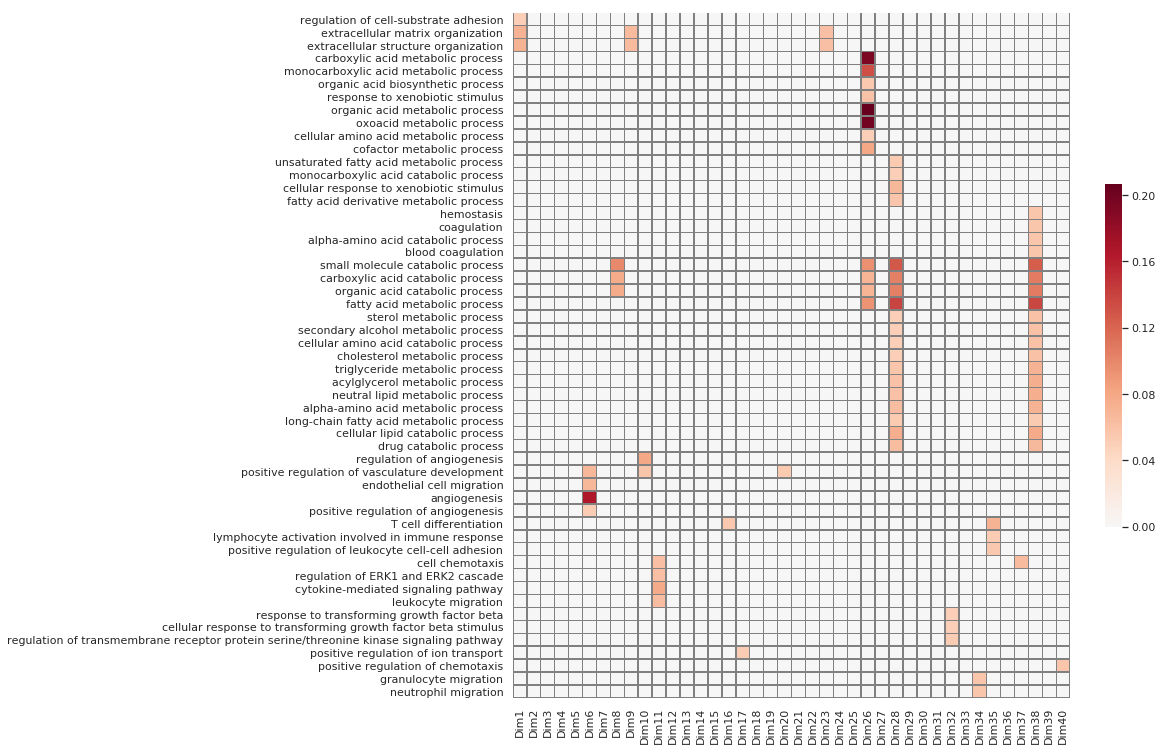

/home/jz286/myenv/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


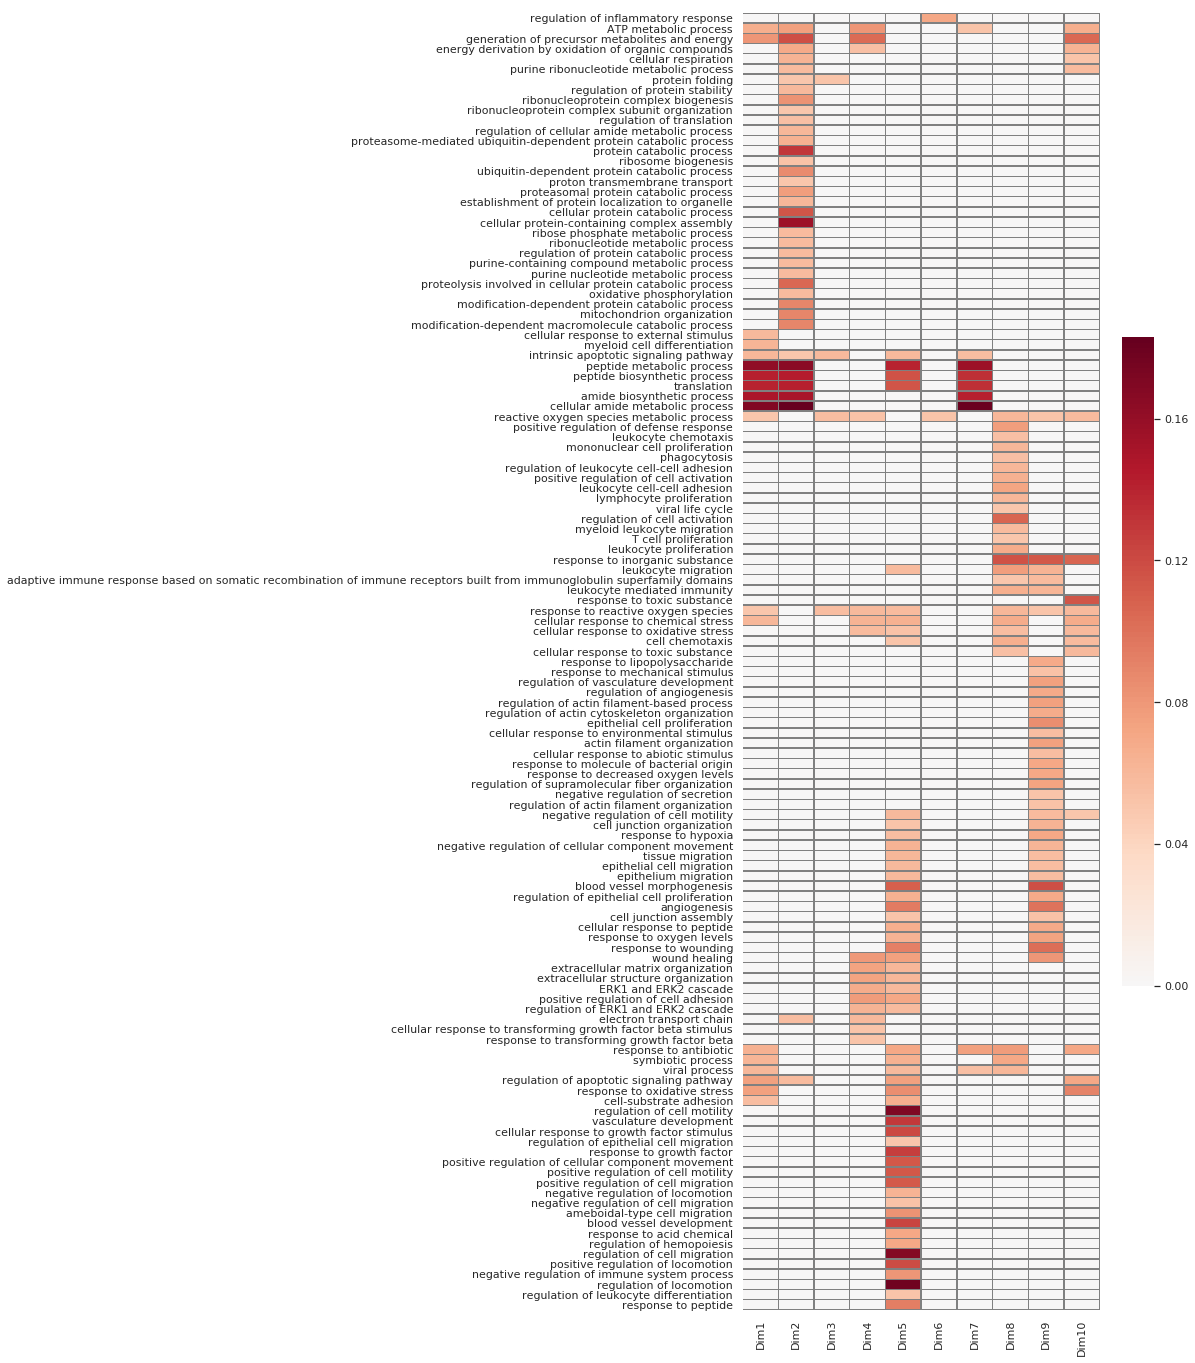

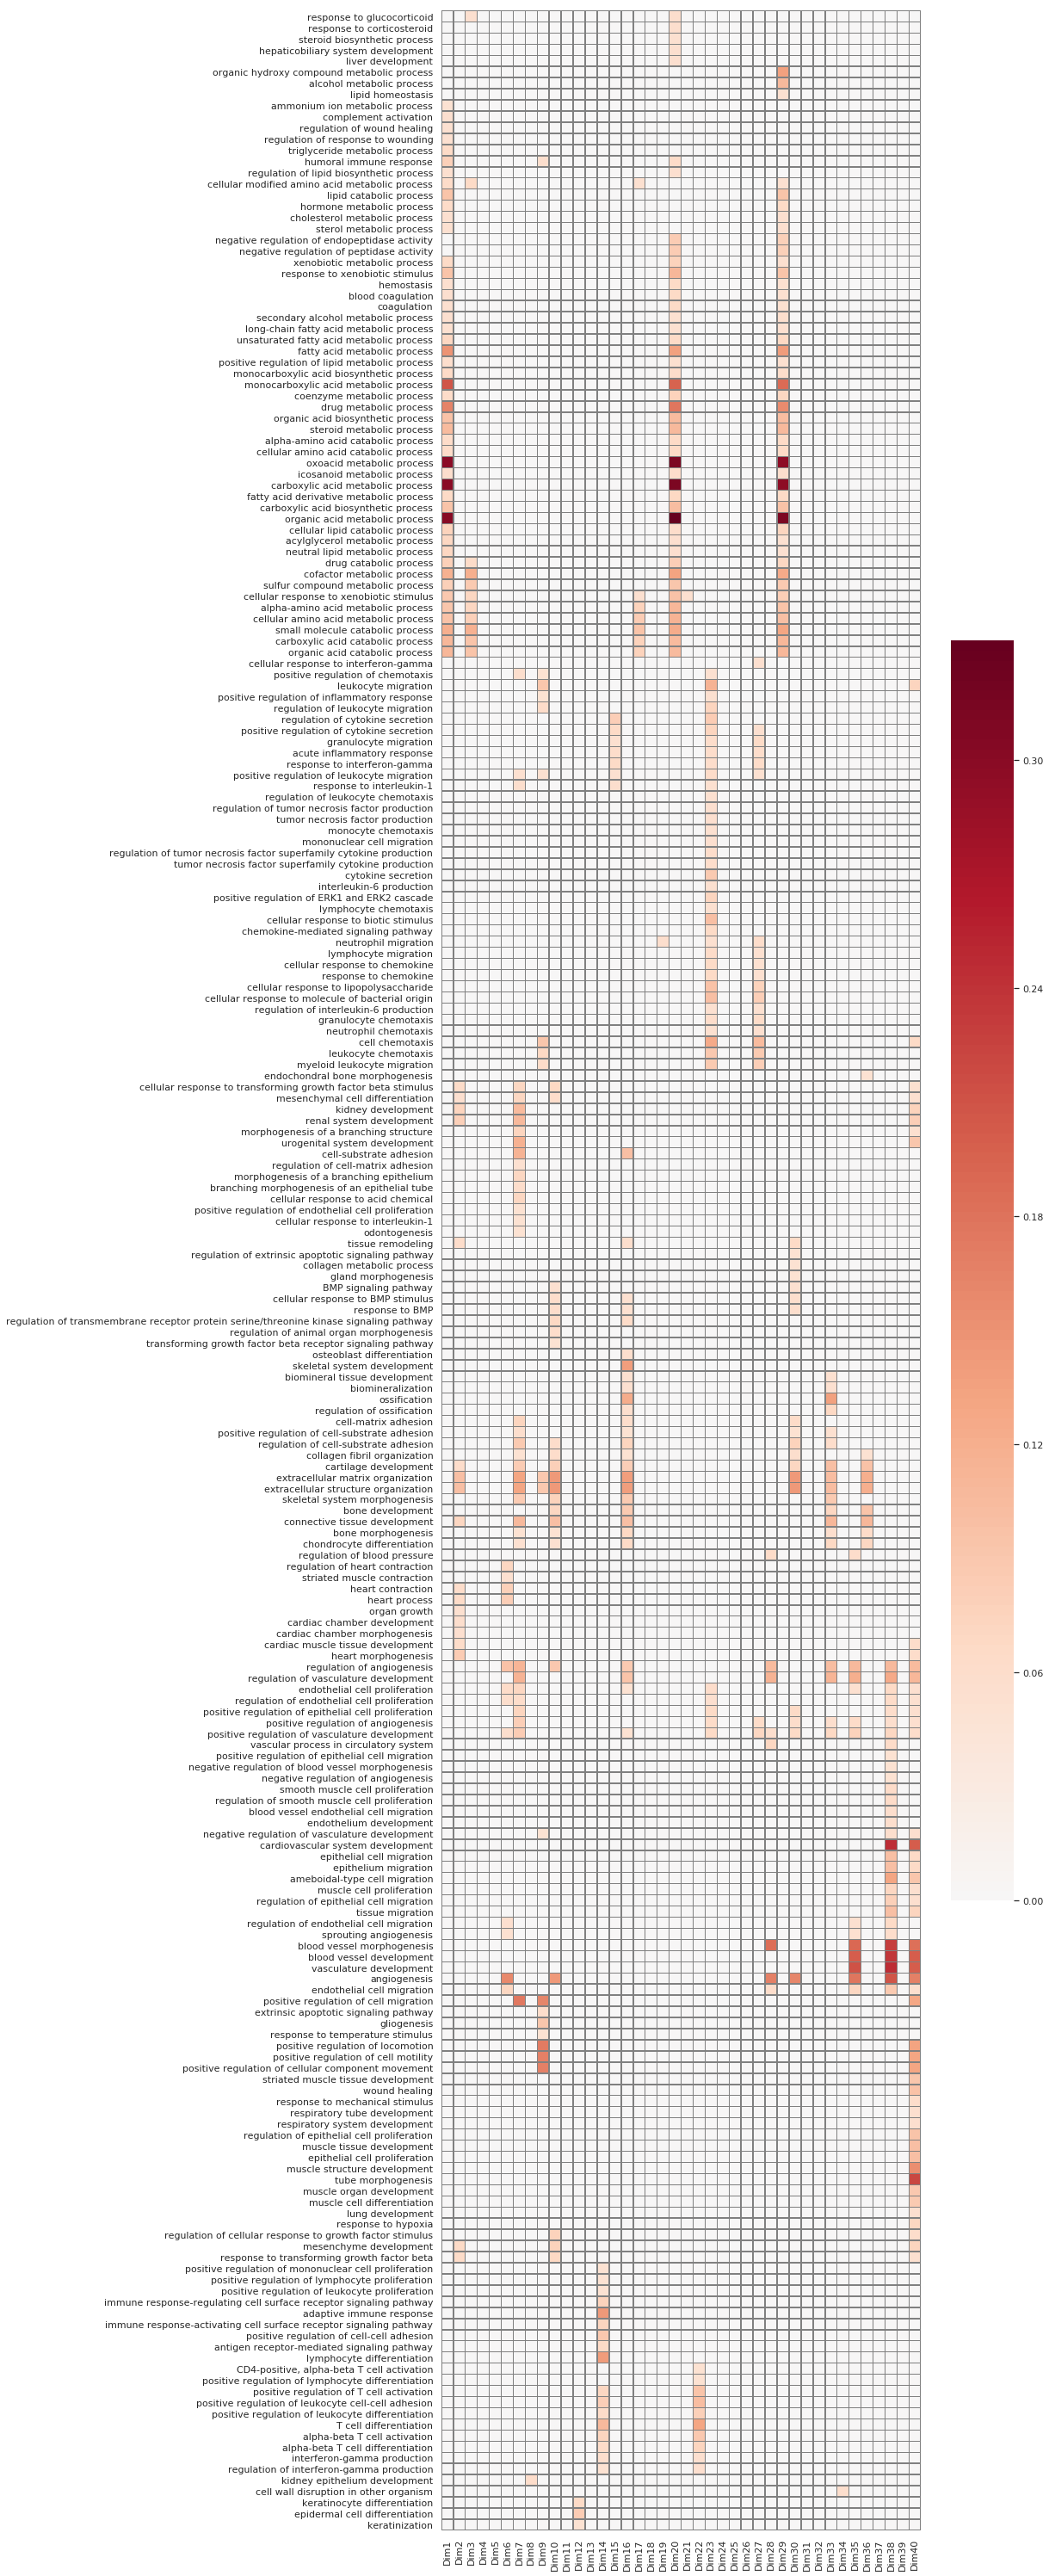

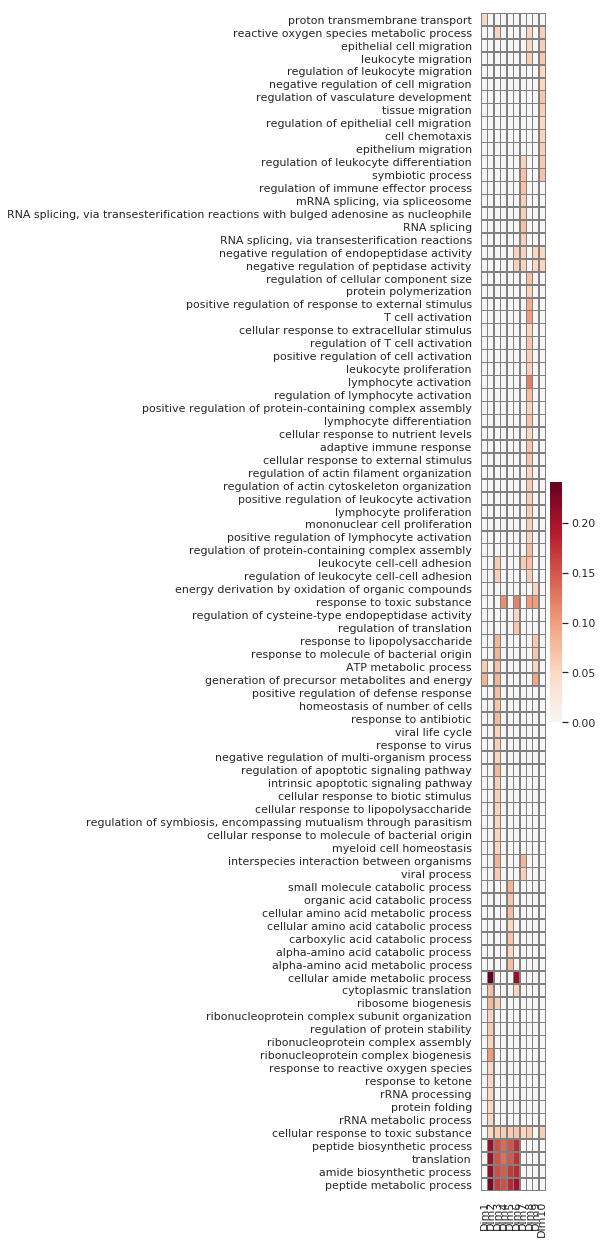

In [20]:
for method in METHOD_LIST:
    for opt in ['nmf', 'svd']:
        
        dic_pathway = dic_sharing['%s.%s'%(opt,method)]['dic_pathway'].copy()
        n_comp = dic_sharing['%s.%s'%(opt,method)]['n_comp']

        df_pathway = pd.DataFrame()
        for i_comp in np.arange(n_comp):

            temp_df = dic_pathway[i_comp].copy()
            temp_df.index = temp_df['name']
            ind_select = (temp_df['term_size']<1000) & (temp_df['precision']>0.05) & (temp_df['recall']>0.1)
            temp_df = temp_df.loc[ind_select, ['precision']]
            temp_df.columns = ['Dim%d'%(i_comp+1)]

            df_pathway = df_pathway.join(temp_df, how='outer')
        df_pathway = df_pathway.fillna(0)

        df_plot = df_pathway.copy()

        temp_y = sp.spatial.distance.pdist(df_plot.values, metric='correlation')
        temp_linkage = sp.cluster.hierarchy.linkage(temp_y, method='average')
        ind_sort = list(df_plot.index[sp.cluster.hierarchy.leaves_list(temp_linkage)])

        plt.figure(figsize=[5 + 0.3*df_plot.shape[1],1+0.18*df_plot.shape[0]])
        sns.heatmap(df_plot.loc[ind_sort], xticklabels=True, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5},
                    linewidths=.5, linecolor='grey')
        plt.xticks(np.arange(df_plot.shape[1])+0.5, list(df_plot.columns), rotation=90)
        plt.ylabel('')
        plt.tight_layout()
        plt.savefig(OUTPUT_PATH_FIG+'/tc_sharing_pathway.%s_%s.pdf'%(opt,method))
        # plt.savefig(OUTPUT_PATH_FIG+'/tc_sharing_pathway.pdf', bbox_inches='tight')
        # plt.savefig(OUTPUT_PATH_FIG+'/tc_sharing_pathway.mashr.pdf')
        plt.show()
#         break
#     break

# Old code

### Weighted-thresholding gene partition: computation


In [162]:
method='facs'
gene_list = dic_gene_anno[method].index[dic_gene_anno[method]['prop_sig_w']>0.5]
gene_list_up = dic_gene_anno[method].index[(dic_gene_anno[method]['prop_sig_w']>0.5) &
                                           (dic_gene_anno[method]['prop_upreg_w']>0.95)]
gene_list_up = list(gene_list_up)
gene_list_down = dic_gene_anno[method].index[(dic_gene_anno[method]['prop_sig_w']>0.5) &
                                           (dic_gene_anno[method]['prop_upreg_w']<0.05)]
gene_list_down = list(gene_list_down)

print('# gene_list', len(gene_list))
print('# gene_list_up', len(gene_list_up))
print('# gene_list_down', len(gene_list_down))
print('# other', len(list(set(gene_list)- set(gene_list_up) - set(gene_list_down))))

# gene_list 330
# gene_list_up 50
# gene_list_down 92
# other 188


# old global aging genes 290
# global aging genes 330
# overlapping 273


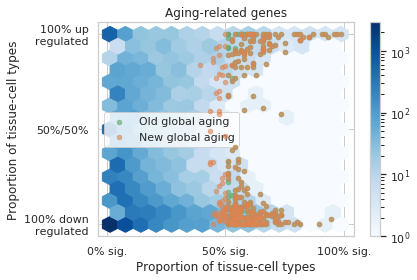

In [157]:
method = 'facs'
list_global_aging_old = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
list_global_aging = gene_list
print('# old global aging genes', len(list_global_aging_old))
print('# global aging genes', len(list_global_aging))
print('# overlapping', len(list(set(list_global_aging) & set(list_global_aging_old))))

ind_select = dic_gene_anno[method]['prop_sig']>0
df_plot = dic_gene_anno[method].loc[ind_select]

plt.figure(figsize=[6,4])

plt.scatter(df_plot.loc[list_global_aging_old, 'prop_sig'],
            df_plot.loc[list_global_aging_old, 'prop_upreg'], 
            color='C2', s=20, alpha=0.6, label='Old global aging', zorder=10)

plt.scatter(df_plot.loc[list_global_aging, 'prop_sig'],
            df_plot.loc[list_global_aging, 'prop_upreg'], 
            color='C1', s=20, alpha=0.6, label='New global aging', zorder=10)
plt.legend()

plt.hexbin(df_plot['prop_sig'], df_plot['prop_upreg'], gridsize=15,
           cmap = 'Blues', bins='log')    
plt.colorbar()

plt.ylabel('Proportion of tissue-cell types')
plt.xlabel('Proportion of tissue-cell types')

plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
plt.title('Aging-related genes')
plt.tight_layout()
plt.show()


In [165]:
# compute aging score model 
df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='equal_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.weighted_thres.equal_weight.tsv', sep='\t')

df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='quantile_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.weighted_thres.quantile_weight.tsv', sep='\t')

### Meta-analyze based gene partition: computation

In [48]:
# Design matrix 
method = 'facs'

df_reg = pd.DataFrame(index = dic_anno[method].index)
df_reg['global'] = 1

# # Add tissue
# for tissue in set(dic_anno[method]['tissue']):
#     df_reg[tissue] = [1 if x==tissue else 0 for x in dic_anno[method]['tissue']]
    
# Add cell category
cell_cate_list = []
for x in dic_anno[method]['cell category']:
    cell_cate_list += x.split(';')
cell_cate_list = list(set(cell_cate_list))
cell_cate_list.sort()

for cate in cell_cate_list:
    df_reg[cate] = [1 if cate in x else 0 for x in dic_anno[method]['cell category']]
    
# Align with dic_coef[method]
analyte_list_reg = list(dic_coef[method].columns)
df_reg = df_reg.loc[analyte_list_reg].copy()

#
df_reg = df_reg.loc[:, df_reg.sum(axis=0)>=5]
print(df_reg.sum(axis=0))


global                  76
endothelial             11
epithelial               8
immune                  25
parenchymal             24
stem cell/progenitor    11
stromal                  5
dtype: int64


In [109]:
method='facs'
# Regression
ind_select = (((dic_bh_p[method]<dic_fdr_threshold[method]) & 
               (np.absolute(dic_coef[method])>coef_threshold)).sum(axis=1)>0)
gene_list_reg = list(dic_coef[method].index[ind_select])
print(method, 'n_gene', len(gene_list_reg))

# Gene level regression 
factor_list = list(df_reg.columns)
factor_list = ['global']
df_res_coef = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=0)
df_res_coef_se = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1e4)
df_res_absz = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)
df_res_raw_p = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)
df_res_bh_p = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)
df_res_fwer = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)

for factor in factor_list:
    temp_list = list(df_reg.index[df_reg[factor]==1])
    for i_gene,gene in enumerate(gene_list_reg):
        
        v_mean = dic_coef[method].loc[gene, temp_list].values
        v_se = dic_coef_se[method].loc[gene, temp_list].values        
        mean_,se_ = util.meta_analysis(v_mean, v_se)
        df_res_coef.loc[gene, factor] = mean_
        df_res_coef_se.loc[gene, factor] = se_
        z_ = np.absolute(mean_/se_)
        df_res_absz.loc[gene, factor] = z_
        df_res_raw_p.loc[gene, factor] = (1 - sp.stats.norm.cdf(z_))*2

        if i_gene%1000 == 0: print(gene, i_gene)
            
#         print('%s\t%s\t%s\t%s\t%s'%(gene,mean_,se_,z_,df_res_raw_p.loc[gene, factor]))
# 
df_res_coef = df_res_coef.fillna(0)
df_res_coef_se = df_res_coef_se.fillna(1e4)
df_res_raw_p = df_res_raw_p.fillna(1)    
# Add bh_p value for multiple comporison
for term in factor_list:
    res_bh = multipletests(df_res_raw_p[term].values, method='fdr_bh')
    df_res_bh_p[term] = res_bh[1]
    df_res_fwer[term] = (df_res_raw_p[term].values*df_res_raw_p.shape[0]).clip(max=1)

facs n_gene 13376
0610005C13Rik 0
Ak3 1000
C1qtnf7 2000
Cplx2 3000
Elk3 4000
Glb1l 5000
Il7r 6000
Mboat1 7000
Nphs2 8000
Pou6f1 9000
Rpl26 10000
Snrnp200 11000
Tmpo 12000
Zbtb8os 13000


# old global aging genes 290
# global aging genes 714
# overlapping 138


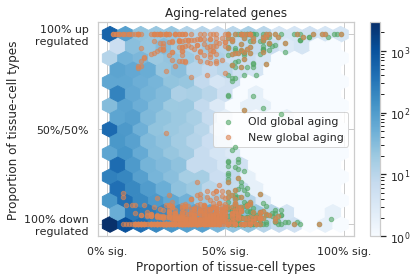

In [112]:
method = 'facs'
list_global_aging_old = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
list_global_aging = list(df_res_bh_p.index[df_res_absz['global']>15])
print('# old global aging genes', len(list_global_aging_old))
print('# global aging genes', len(list_global_aging))
print('# overlapping', len(list(set(list_global_aging) & set(list_global_aging_old))))

ind_select = dic_gene_anno[method]['Prop. of Sig.']>0
df_plot = dic_gene_anno[method].loc[ind_select]

plt.figure(figsize=[6,4])

plt.scatter(df_plot.loc[list_global_aging_old, 'Prop. of Sig.'],
            df_plot.loc[list_global_aging_old, 'Prop. of +'], 
            color='C2', s=20, alpha=0.6, label='Old global aging', zorder=10)

plt.scatter(df_plot.loc[list_global_aging, 'Prop. of Sig.'],
            df_plot.loc[list_global_aging, 'Prop. of +'], 
            color='C1', s=20, alpha=0.6, label='New global aging', zorder=10)
plt.legend()

plt.hexbin(df_plot['Prop. of Sig.'], df_plot['Prop. of +'], gridsize=15,
           cmap = 'Blues', bins='log')    
plt.colorbar()

plt.ylabel('Proportion of tissue-cell types')
plt.xlabel('Proportion of tissue-cell types')

plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
plt.title('Aging-related genes')
plt.tight_layout()
plt.show()


In [116]:
# compute aging score model 
gene_list_up = list(df_res_bh_p.index[(df_res_absz['global']>15) & (df_res_coef['global']>0)])
gene_list_down = list(df_res_bh_p.index[(df_res_absz['global']>15) & (df_res_coef['global']<0)])
# print('# gene_list', len(gene_list))
print('# gene_list_up', len(gene_list_up))
print('# gene_list_down', len(gene_list_down))
df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='equal_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.meta_gene.equal_weight.tsv', sep='\t')

df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='quantile_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.meta_gene.quantile_weight.tsv', sep='\t')

# gene_list_up 187
# gene_list_down 527


### Regression-based gene partition: computation

In [123]:
# Design matrix 
method = 'facs'

df_reg = pd.DataFrame(index = dic_anno[method].index)
df_reg['global'] = 1

# # Add tissue
# for tissue in set(dic_anno[method]['tissue']):
#     df_reg[tissue] = [1 if x==tissue else 0 for x in dic_anno[method]['tissue']]
    
# Add cell category
cell_cate_list = []
for x in dic_anno[method]['cell category']:
    cell_cate_list += x.split(';')
cell_cate_list = list(set(cell_cate_list))
cell_cate_list.sort()

for cate in cell_cate_list:
    df_reg[cate] = [1 if cate in x else 0 for x in dic_anno[method]['cell category']]
    
# Align with dic_coef[method]
analyte_list_reg = list(dic_coef[method].columns)
df_reg = df_reg.loc[analyte_list_reg].copy()

#
df_reg = df_reg.loc[:, df_reg.sum(axis=0)>=5]
print(df_reg.sum(axis=0))


global                  76
endothelial             11
epithelial               8
immune                  25
parenchymal             24
stem cell/progenitor    11
stromal                  5
dtype: int64


In [124]:
# weight
temp_df = dic_anno['facs'][['n_cell', 'n_celltype']].copy()
temp_df = temp_df.loc[analyte_list_reg]
v_w = np.ones([temp_df.shape[0]])
v_w = v_w * temp_df['n_cell'].values # by sample size
v_w = v_w / temp_df['n_celltype'].values # by n_celltype in each tissue
v_w = v_w / v_w.mean()
v_w = np.sqrt(v_w)

In [125]:
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Regression
ind_select = (((dic_bh_p[method]<dic_fdr_threshold[method]) & 
               (np.absolute(dic_coef[method])>coef_threshold)).sum(axis=1)>0)
gene_list_reg = list(dic_coef[method].index[ind_select])
print(method, 'n_gene', len(gene_list_reg))

# Gene level regression 
mat_X = df_reg.values
factor_list = list(df_reg.columns)
df_res_raw_p = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)
df_res_coef = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=0)
df_res_bh_p = pd.DataFrame(columns=factor_list, index=gene_list_reg, data=1)

# Apply weights
mat_X = (mat_X.T*v_w).T

for i_gene,gene in enumerate(gene_list_reg):

    v_y = dic_coef[method].loc[gene].values
    v_y = v_y*v_w
    res = sm.OLS(v_y, mat_X).fit()

    df_res_raw_p.loc[gene] = res.pvalues
    df_res_coef.loc[gene] = res.params

    if i_gene%1000 == 0: print(gene, i_gene)
        
#     break
        
# Add bh_p value for multiple comporison
for term in factor_list:
    res_bh = multipletests(df_res_raw_p[term].values, method='fdr_bh')
    df_res_bh_p[term] = res_bh[1]

facs n_gene 13376
0610005C13Rik 0
Ak3 1000
C1qtnf7 2000
Cplx2 3000
Elk3 4000
Glb1l 5000
Il7r 6000
Mboat1 7000
Nphs2 8000
Pou6f1 9000
Rpl26 10000
Snrnp200 11000
Tmpo 12000
Zbtb8os 13000


# old global aging genes 290
# global aging genes 533
# overlapping 70


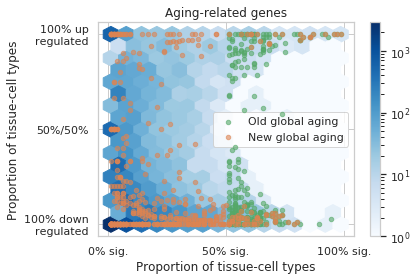

In [129]:
method = 'facs'
list_global_aging_old = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
list_global_aging = list(df_res_bh_p.index[df_res_bh_p['global']<0.05])
print('# old global aging genes', len(list_global_aging_old))
print('# global aging genes', len(list_global_aging))
print('# overlapping', len(list(set(list_global_aging) & set(list_global_aging_old))))

ind_select = dic_gene_anno[method]['Prop. of Sig.']>0
df_plot = dic_gene_anno[method].loc[ind_select]

plt.figure(figsize=[6,4])

plt.scatter(df_plot.loc[list_global_aging_old, 'Prop. of Sig.'],
            df_plot.loc[list_global_aging_old, 'Prop. of +'], 
            color='C2', s=20, alpha=0.6, label='Old global aging', zorder=10)

plt.scatter(df_plot.loc[list_global_aging, 'Prop. of Sig.'],
            df_plot.loc[list_global_aging, 'Prop. of +'], 
            color='C1', s=20, alpha=0.6, label='New global aging', zorder=10)
plt.legend()

plt.hexbin(df_plot['Prop. of Sig.'], df_plot['Prop. of +'], gridsize=15,
           cmap = 'Blues', bins='log')    
plt.colorbar()

plt.ylabel('Proportion of tissue-cell types')
plt.xlabel('Proportion of tissue-cell types')

plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
plt.title('Aging-related genes')
plt.tight_layout()
plt.show()


In [115]:
temp_facs = util.load_normalized_data(DATA_PATH, data_name='facs', 
                                      flag_size_factor=True, flag_log1p=True)

Trying to set attribute `.obs` of view, copying.


In [140]:
# compute aging score model 
gene_list_up = list(df_res_bh_p.index[(df_res_bh_p['global']<0.05) & (df_res_coef['global']>0)])
gene_list_down = list(df_res_bh_p.index[(df_res_bh_p['global']<0.05) & (df_res_coef['global']<0)])
print('# gene_list', len(gene_list))
print('# gene_list_up', len(gene_list_up))
print('# gene_list_down', len(gene_list_down))
df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='equal_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.reg_gene.equal_weight.tsv', sep='\t')

df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='quantile_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.reg_gene.quantile_weight.tsv', sep='\t')

# gene_list 533
# gene_list_up 109
# gene_list_down 424


In [141]:
# aging score model for original global aging genes 
# compute aging score model 
gene_list_up = list(dic_gene_anno['facs'].index[dic_gene_anno['facs']['global.dir']=='up'])
gene_list_down = list(dic_gene_anno['facs'].index[dic_gene_anno['facs']['global.dir']=='down'])
print('# gene_list_up', len(gene_list_up))
print('# gene_list_down', len(gene_list_down))
df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='equal_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.old.equal_weight.tsv', sep='\t')

df_aging_model = util.compute_aging_score_model(temp_facs, gene_list_up, gene_list_down,
                                                option='quantile_weight')
df_aging_model.to_csv(OUTPUT_PATH_TEMP+'/aging_model.old.quantile_weight.tsv', sep='\t')

# gene_list_up 93
# gene_list_down 168


### Old code

In [ ]:
# import statsmodels.api as sm
# from statsmodels.stats.multitest import multipletests
# from sklearn.decomposition import PCA

# dic_part_gene = {}
# for method in ['facs']:
    
#     cell_cate_list = []
#     for x in dic_anno[method]['cell category']:
#         cell_cate_list += x.split(';')
#     cell_cate_list = list(set(cell_cate_list))
#     cell_cate_list.sort()
    
#     analyte_list_reg = list(dic_coef[method].columns)

#     # Design matrix: functional categories 
#     df_reg = pd.DataFrame(index = dic_anno[method].index)
#     df_reg['global'] = 1
#     for cate in cell_cate_list:
#         df_reg[cate] = [1 if cate in x else 0 
#                         for x in dic_anno[method]['cell category']]
#     df_reg = df_reg.loc[analyte_list_reg]
        
#     # Repsonses: gene level 
#     ind_select = (((dic_bh_p[method]<dic_fdr_threshold[method]) & 
#                    (np.absolute(dic_coef[method])>coef_threshold)).sum(axis=1)>0)
#     gene_list_reg = list(dic_coef[method].index[ind_select])
#     print(method, 'n_gene', ind_select.sum())
    
#     # Gene level regression 
#     mat_X = df_reg.values
#     col_name_raw_p = ['%s.raw_p'%x for x in df_reg.columns]
#     col_name_coef = ['%s.coef'%x for x in df_reg.columns]
# #     col_name_bh_p = ['%s.bh_p'%x for x in df_reg.columns]
    
#     df_res_raw_p = pd.DataFrame(columns=col_name_raw_p, index=gene_list_reg, data=1)
#     df_res_coef = pd.DataFrame(columns=col_name_coef, index=gene_list_reg, data=0)
# #     df_res_bh_p = pd.DataFrame(columns=col_name_bh_p, index=gene_list_reg, data=1)

#     for i_gene,gene in enumerate(gene_list_reg):
        
#         v_y = dic_coef[method].loc[gene].values
#         mod = sm.OLS(v_y, mat_X)
#         res = mod.fit()
        
#         df_res_raw_p.loc[gene] = res.pvalues
#         df_res_coef.loc[gene] = res.params
# #         res_bh = multipletests(res.pvalues, method='fdr_bh')
# #         df_res_bh_p.loc[gene] = res_bh[1]
        
#         if i_gene%500 == 0: print(gene, i_gene)
        
# #         if i_gene==0: break
    
#     # store the results 
#     dic_part_gene[method] = pd.DataFrame(index=gene_list_reg)
#     dic_part_gene[method] = dic_part_gene[method].join(df_res_raw_p)
#     dic_part_gene[method] = dic_part_gene[method].join(df_res_coef)
# #     dic_part_gene[method] = dic_part_gene[method].join(df_res_bh_p)

In [ ]:
method = 'facs'
for method in ['facs']:
    list_global_aging_old = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
    list_global_aging = list(dic_part_gene[method].index[dic_part_gene[method]['global.bh_p']<0.05])
    print('# old global aging genes', len(list_global_aging_old))
    print('# global aging genes', len(list_global_aging))
    
    ind_select = dic_gene_anno[method]['Prop. of Sig.']>0
    df_plot = dic_gene_anno[method].loc[ind_select]
    
    plt.figure(figsize=[6,4])

    plt.scatter(df_plot.loc[list_global_aging_old, 'Prop. of Sig.'],
                df_plot.loc[list_global_aging_old, 'Prop. of +'], 
                color='C2', s=20, alpha=0.6, label='Old global aging', zorder=10)
    
    plt.scatter(df_plot.loc[list_global_aging, 'Prop. of Sig.'],
                df_plot.loc[list_global_aging, 'Prop. of +'], 
                color='C1', s=20, alpha=0.6, label='New global aging', zorder=10)
    plt.legend()

    plt.hexbin(df_plot['Prop. of Sig.'], df_plot['Prop. of +'], gridsize=15,
               cmap = 'Blues', bins='log')    
    plt.colorbar()

    plt.ylabel('Proportion of tissue-cell types')
    plt.xlabel('Proportion of tissue-cell types')

    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    plt.title('Aging-related genes')
    plt.tight_layout()
    plt.show()
    break


### Original gene partition: tissue-cell specific aging


In [27]:
category_list = ['immune', 'stem cell/progenitor', 'stromal',
                 'endothelial', 'epithelial', 'parenchymal',]
df_tc_specificity = pd.DataFrame(index=df_global_aging_gene.index)
# get data 
temp_df = df_global_aging_gene.copy()
temp_df.columns = [x.replace('.Sig.', '') for x in temp_df.columns]
for cate in category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']]
    df_tc_specificity['%s.n_celltype'%cate] = np.sum(ind_select)
    cell_type_select = df_cell_category.index[ind_select]
    df_tc_specificity['%s.n_sig'%cate] = temp_df.loc[:,cell_type_select].sum(axis=1)
    # fc
    df_tc_specificity['%s.fc'%cate] = df_fc_MAST[cell_type_select].median(axis=1)
    # add place holders
    df_tc_specificity['%s.raw_p'%cate] = 1
    df_tc_specificity['%s.bh_p'%cate] = 1

In [28]:
# Test fror tissue-cell type specificity 
for cate in category_list:
    other_cate_list = category_list.copy()
    other_cate_list.remove(cate)
    print(cate, other_cate_list)    
    ind_select = (df_tc_specificity['%s.n_sig'%cate]>0)
    for gene_name in df_tc_specificity.index[ind_select]:
        rej_cate = df_tc_specificity.loc[gene_name, '%s.n_sig'%cate]
        non_rej_cate = df_tc_specificity.loc[gene_name, '%s.n_celltype'%cate] - rej_cate
        
        temp_list = ['%s.n_sig'%x for x in other_cate_list]
        rej_other = np.sum(df_tc_specificity.loc[gene_name, temp_list])
        
        temp_list = ['%s.n_celltype'%x for x in other_cate_list]
        non_rej_other = np.sum(df_tc_specificity.loc[gene_name, temp_list]) - rej_other
        
        test_table = [[rej_cate, rej_other],
                      [non_rej_cate, non_rej_other]]
        
        _,p_val = sp.stats.fisher_exact(test_table, alternative='greater')
        df_tc_specificity.loc[gene_name, '%s.raw_p'%cate] = p_val
    # Add bh_p
    res_bh = multipletests(df_tc_specificity['%s.raw_p'%cate],
                           alpha=0.2, method='fdr_bh')
    df_tc_specificity['%s.bh_p'%cate] = res_bh[1]
#     break

immune ['stem cell/progenitor', 'stromal', 'endothelial', 'epithelial', 'parenchymal']
stem cell/progenitor ['immune', 'stromal', 'endothelial', 'epithelial', 'parenchymal']
stromal ['immune', 'stem cell/progenitor', 'endothelial', 'epithelial', 'parenchymal']
endothelial ['immune', 'stem cell/progenitor', 'stromal', 'epithelial', 'parenchymal']
epithelial ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'parenchymal']
parenchymal ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'epithelial']


In [29]:
# select tissue-cell type specific genes 
dic_tc_specific_gene = {}
ind_tc = ((temp_df.mean(axis=1))<0.1) & ((temp_df.mean(axis=1))>0)
for cate in category_list:
    ind_select = df_tc_specificity['%s.bh_p'%cate]<0.25
    dic_tc_specific_gene[cate] = list(df_tc_specificity.index[ind_select])
    print(cate, np.sum(ind_select))

immune 204
stem cell/progenitor 197
stromal 1
endothelial 104
epithelial 0
parenchymal 0


/home/martin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


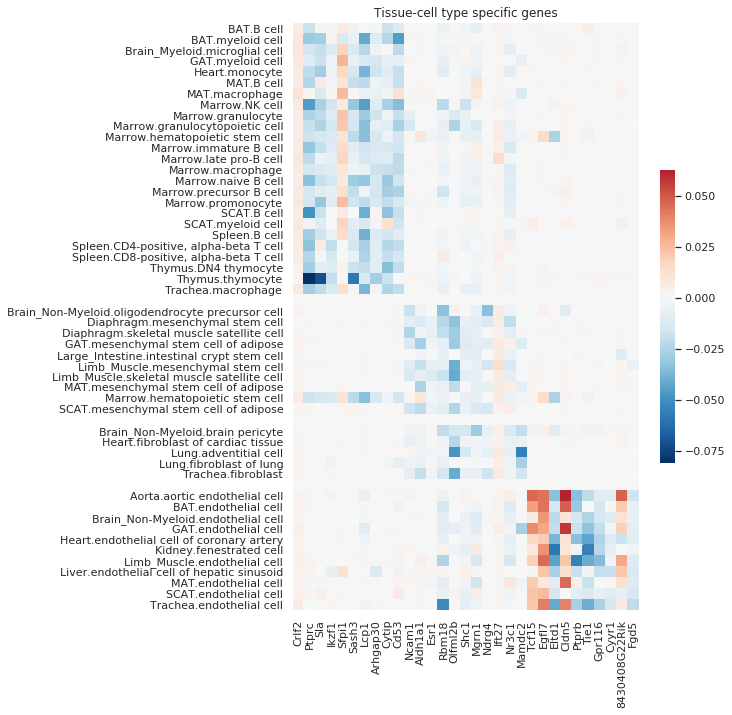

In [30]:
# visualize top genes 
temp_gene_list = []
for cate in category_list:
    temp_df = df_tc_specificity.copy()
    temp_df = temp_df.sort_values(by='%s.bh_p'%cate)
    temp_df = temp_df.iloc[0:10]
    temp_df = temp_df.loc[temp_df['%s.bh_p'%cate]<0.25]
    temp_gene_list += list(temp_df.index)
# reoroder analysis_list 
temp_category_list = ['immune', 'stem cell/progenitor', 'stromal', 'endothelial']

analysis_list_reorder = []
for cate in temp_category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']]
    temp_list = list(df_cell_category.index[ind_select])
    for analyte in temp_list:
        if analyte in analysis_list_reorder:
            temp_list.remove(analyte)
    temp_list.sort()
    analysis_list_reorder += temp_list
    if cate!=temp_category_list[-1]:
        analysis_list_reorder += ['']
gene_list_select = temp_gene_list
# visualization
temp_df = df_fc_MAST.loc[gene_list_select, analysis_list_reorder]
temp_df = temp_df.fillna(value=0)
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Tissue-cell type specific genes')
plt.savefig(output_folder_fig + '/tc_specific_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [31]:
# Save for IPA ``
for cate in category_list:
    temp_gene_list = dic_tc_specific_gene[cate]
    temp_df = df_tc_specificity.loc[temp_gene_list, ['%s.raw_p'%cate, '%s.bh_p'%cate,
                                                     '%s.fc'%cate]]
    temp_df = temp_df.sort_values(by='%s.bh_p'%cate)
    if temp_df.shape[0]>5:
        temp_df.to_excel(output_folder_tab+'/tc.%s.aging.xls'%cate[0:4])
#     break

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


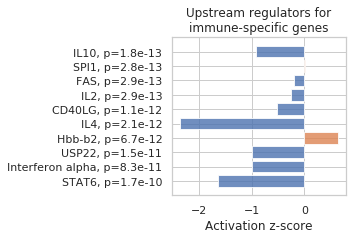

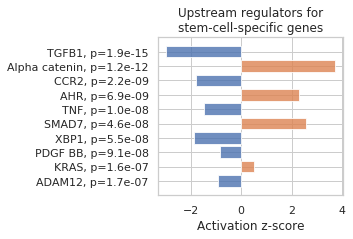

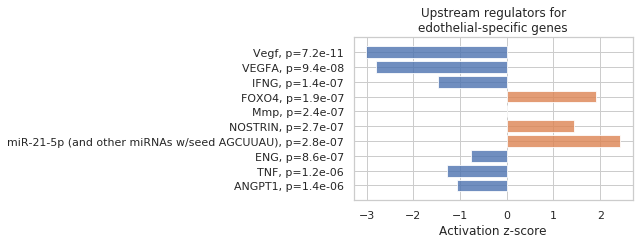

In [92]:
# Visualize the upstream regulator
for cate in ['immu', 'stem', 'endo']:
    temp_df = pd.read_excel(output_folder_tab + '/tc_%s_aging_upstream_regulators.xls'%cate,
                            header=1)
    temp_df.index = temp_df['Upstream Regulator']
    temp_df = temp_df.iloc[0:10]
    temp_df = temp_df.iloc[::-1]
    # figure
    plt.figure(figsize=[5,3])
    ind_select = temp_df['Activation z-score']>0
    plt.barh(np.arange(temp_df.shape[0])[ind_select], 
             temp_df.loc[ind_select, 'Activation z-score'],
             color = 'C1', alpha=0.8)
    ind_select = temp_df['Activation z-score']<=0
    plt.barh(np.arange(temp_df.shape[0])[ind_select], 
             temp_df.loc[ind_select, 'Activation z-score'],
             color = 'C0', alpha=0.8)
    y_tick_list = ['%s, p=%0.1e'%(x,y) for x,y in 
                   zip(temp_df.index, temp_df['p-value of overlap'])]
    plt.yticks(np.arange(temp_df.shape[0]), y_tick_list)
    plt.ylim([-1, temp_df.shape[0]])
    plt.xlabel('Activation z-score')
    plt.tight_layout()
    if cate=='immu':
        plt.title('Upstream regulators for\nimmune-specific genes')
    elif cate=='stem':
        plt.title('Upstream regulators for\nstem-cell-specific genes')
    else:
        plt.title('Upstream regulators for\nedothelial-specific genes')
    plt.savefig(output_folder_fig + '/tc_%s_up_regulator.pdf'%cate,
                transparent=True,  bbox_inches='tight')
#     break

### Heatmap of some interesting genes

In [32]:
anno_data_folder

'/data3/martin/tms_gene_data/annotation_data'

In [33]:
dic_interesting_gene_list = {}

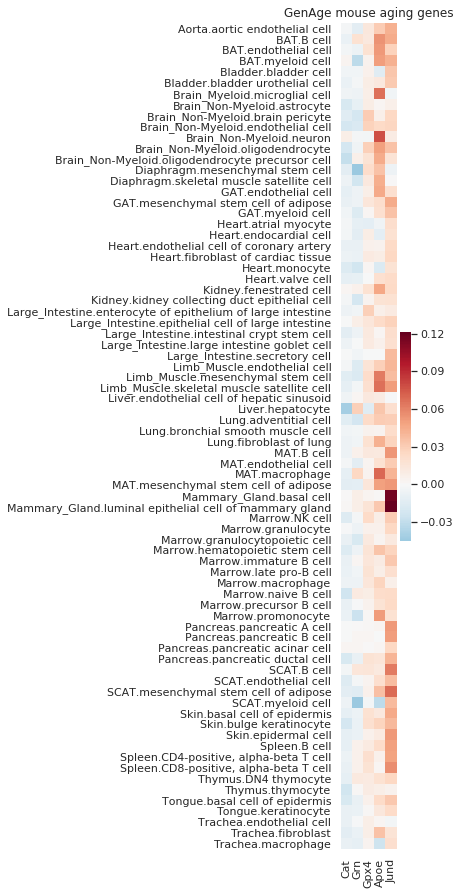

In [34]:
# AgeGen genes
df_agegen = pd.read_csv(anno_data_folder + '/GenAge/genage_models.csv')
df_agegen = df_agegen.loc[df_agegen['organism'] == 'Mus musculus']
temp_gene_list = set(df_agegen['symbol']) & set(df_global_aging_gene.index)
dic_interesting_gene_list['AgeGen'] = temp_gene_list.copy()
temp_df = df_global_aging_gene.loc[temp_gene_list]
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('GenAge mouse aging genes')
plt.savefig(output_folder_fig + '/tc_GenAge_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

Index(['App', 'Ctnnb1', 'Mapk1', 'Rac1', 'Arf1', 'Junb', 'Jund'], dtype='object')


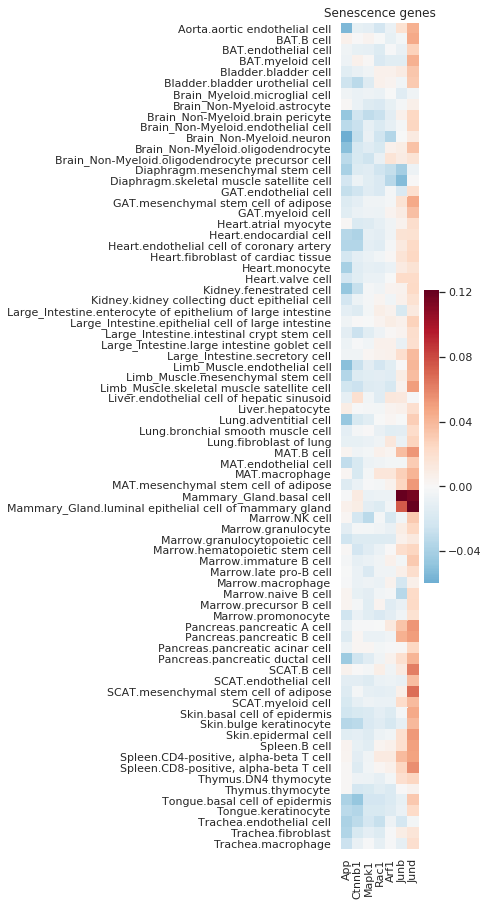

In [35]:
# senescence gene
gene_file = anno_data_folder + '/senescence_227.txt'
temp_gene_list = []
with open(gene_file) as f:
    for line in f:
        temp_gene_list.append(line.strip())
temp_gene_list = set(temp_gene_list) & set(df_global_aging_gene.index)
dic_interesting_gene_list['Senescence'] = temp_gene_list.copy()
temp_df = df_global_aging_gene.loc[temp_gene_list]
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
print(temp_df.columns)
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Senescence genes')
plt.savefig(output_folder_fig + '/tc_senescence_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

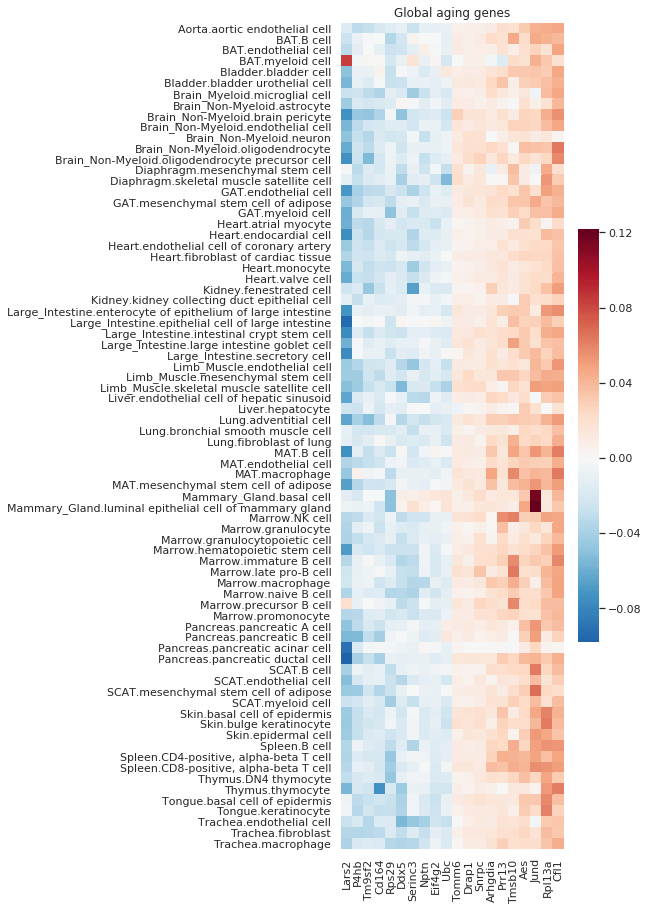

In [36]:
# Visualize global aging genes
gene_name_list = np.array(df_global_aging_gene.index)
# 10 up-regulated genes 
ind_select = (df_global_aging_gene['Prop. of Sig.']>0.5) & \
                    (df_global_aging_gene['Prop. of +']>0.8)
temp_df = df_global_aging_gene.loc[ind_select]
temp_df = temp_df.sort_values(by = 'Prop. of Sig.', ascending=False)
gene_list_select = list(temp_df.index[0:10])
# 10 down-regulated genes 
ind_select = (df_global_aging_gene['Prop. of Sig.']>0.5) & \
                    (df_global_aging_gene['Prop. of +']<0.2)
temp_df = df_global_aging_gene.loc[ind_select]
temp_df = temp_df.sort_values(by = 'Prop. of Sig.', ascending=False)
gene_list_select = gene_list_select + list(temp_df.index[0:10])
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Global aging genes')
plt.savefig(output_folder_fig + '/tc_top_global_aging_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

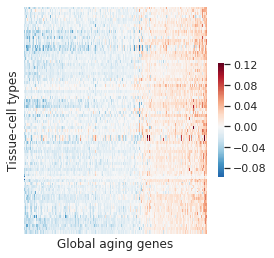

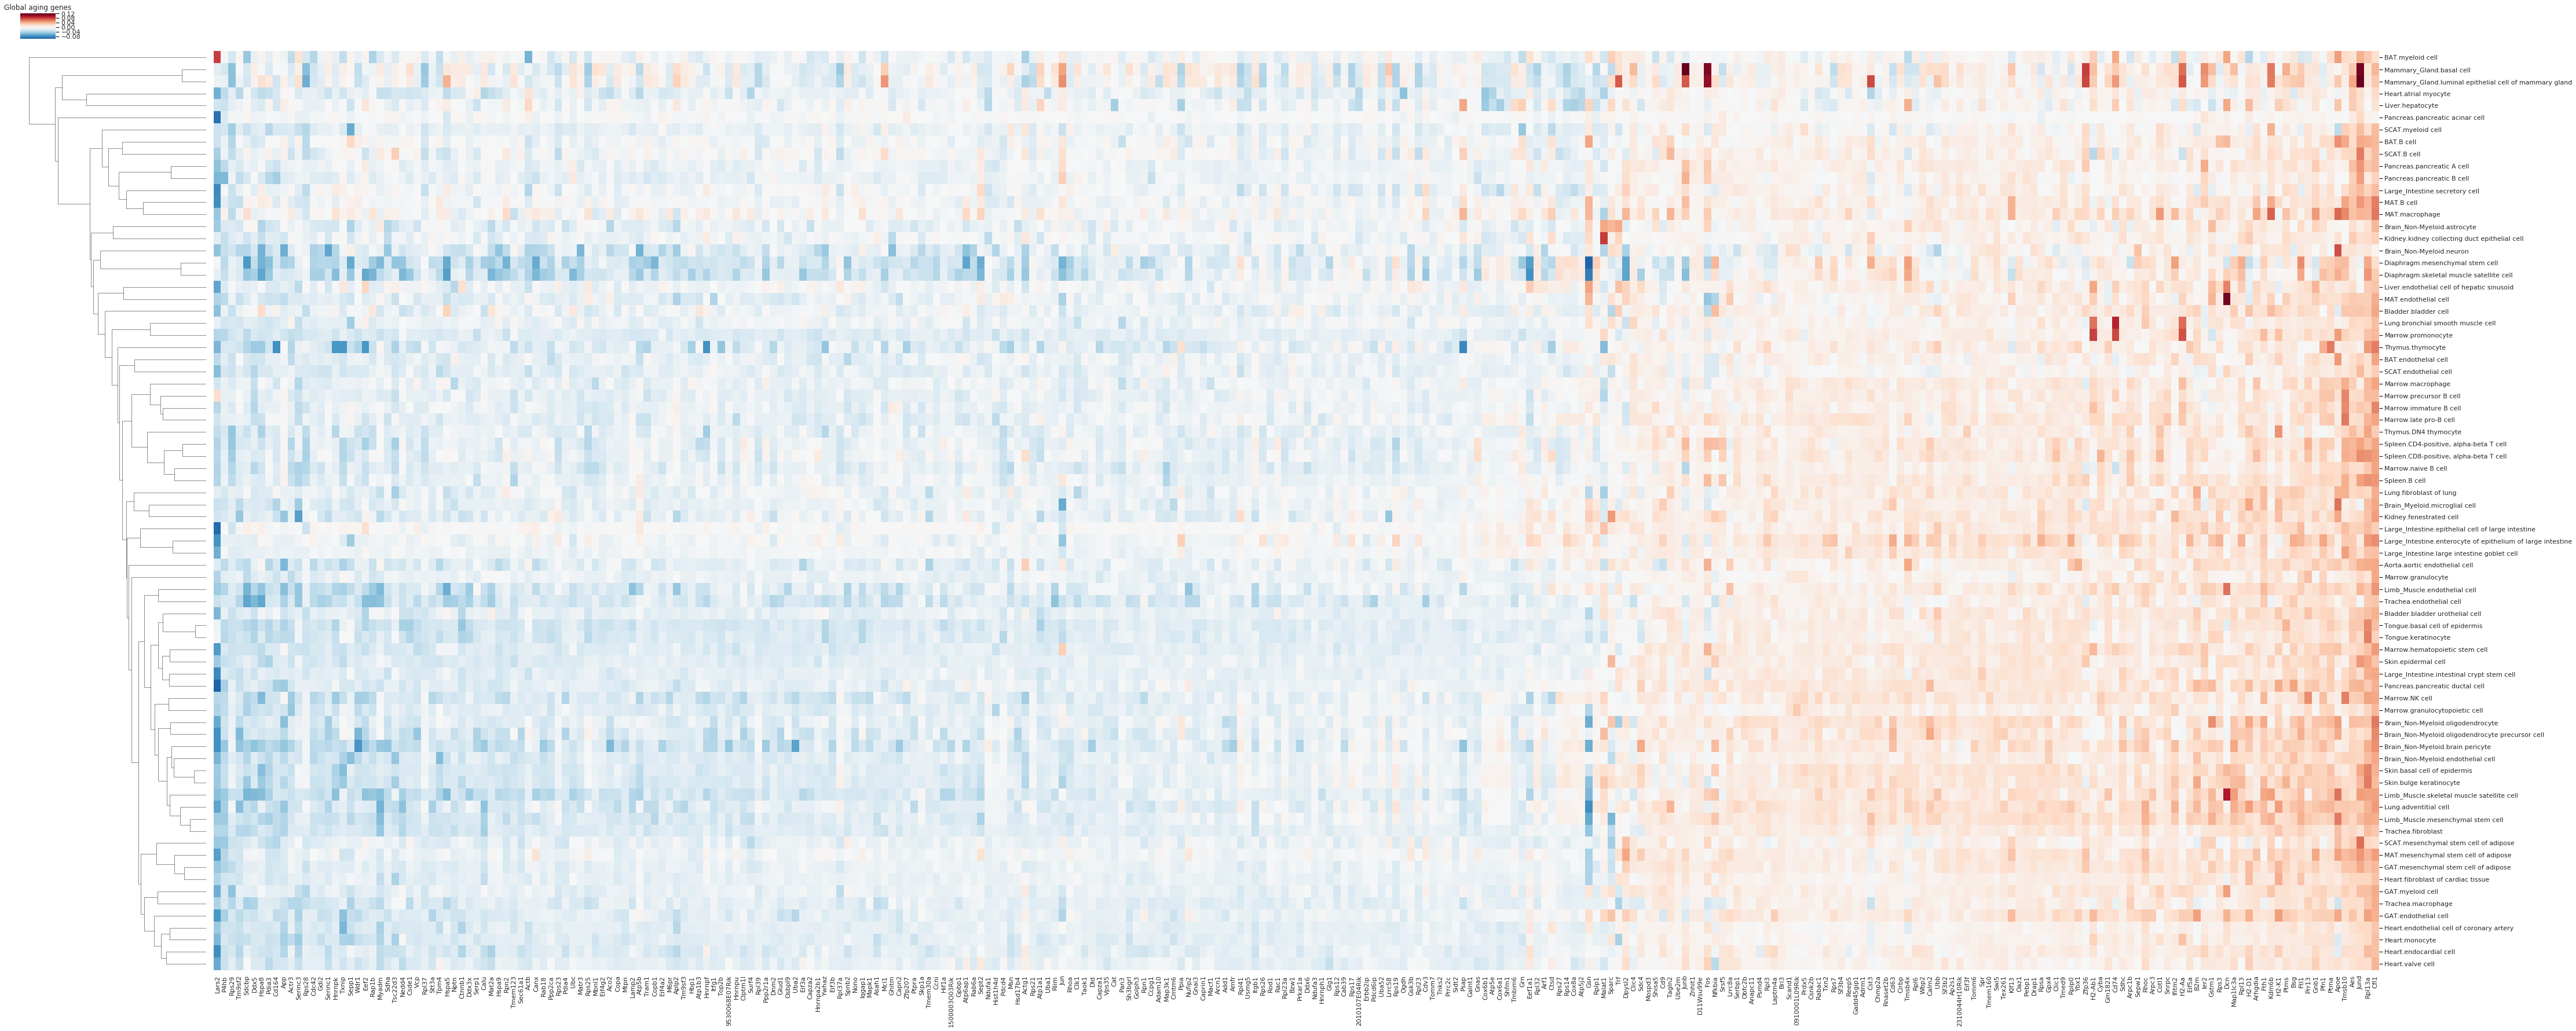

In [37]:
# Visualize global aging genes
# method = 'FACS'
global_aging_gene_list = dic_global_aging_gene['all']
temp_df = df_fc_MAST.loc[global_aging_gene_list]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.mean(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
plt.figure(figsize = [0.014*temp_df.shape[1], 0.055*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=False, yticklabels=False,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.xlabel('Global aging genes')
plt.ylabel('Tissue-cell types')
plt.savefig(output_folder_fig + '/tc_all_global_aging_gene_heatmap_small.pdf',
            transparent=True, bbox_inches='tight')
plt.show()
# visualization: whole
sns.clustermap(temp_df, xticklabels=True, yticklabels=True,
               row_cluster=True, metric='correlation', 
               col_cluster=False, 
               figsize = [0.25*temp_df.shape[1], 0.4*temp_df.shape[0]],
               cmap = 'RdBu_r', center=0)
plt.title('Global aging genes')
plt.savefig(output_folder_fig + '/tc_all_global_aging_gene_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

Index(['Tsc22d3', 'Hnrnpk', 'Jun', 'Ctnnb1', 'Hbp1', 'Gpbp1', 'Hif1a', 'Fos',
       'Junb', 'Ier2', 'Klf13', 'Ybx1', 'Jund'],
      dtype='object')


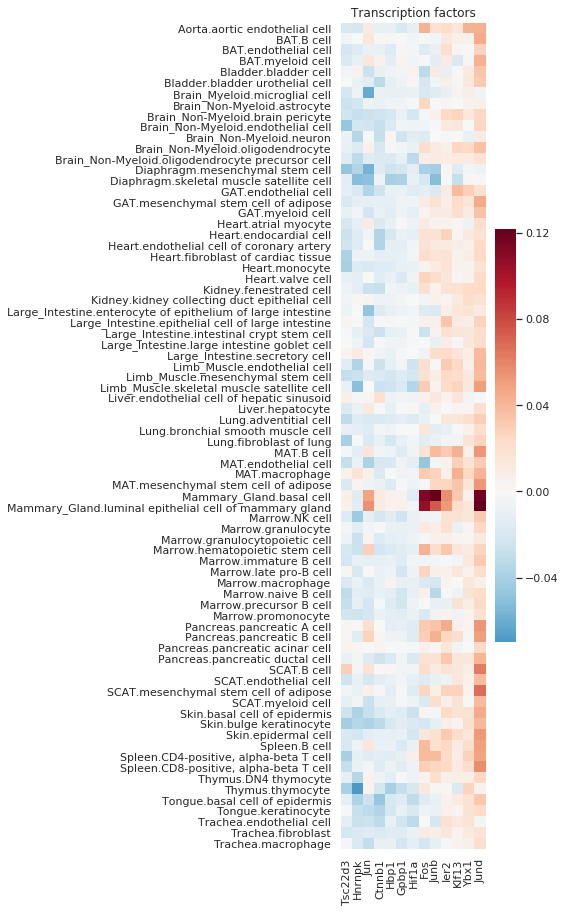

In [38]:
# TF genes
temp_f_name =  anno_data_folder + '/GO_term_summary_20171110_222852.csv'
temp_df = pd.read_csv(temp_f_name)
tf_list = list(set(temp_df['Symbol']) & set(df_global_aging_gene.index))
dic_interesting_gene_list['TF'] = tf_list.copy()
temp_df = df_global_aging_gene.loc[tf_list].copy()
gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
# visualization
temp_df = df_fc_MAST.loc[gene_list_select]
temp_df = temp_df.fillna(value=0)
ind_sort = list(np.argsort(temp_df.median(axis=1)))
temp_df = temp_df.iloc[ind_sort]
temp_df = temp_df.T
# visualization: overview
print(temp_df.columns)
plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
plt.title('Transcription factors')
plt.savefig(output_folder_fig + '/tc_TF_heatmap.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [39]:
df_tf = pd.read_csv(temp_f_name)
df_tf.index = df_tf['Symbol']
df_tf = df_tf.loc[temp_df.columns, ['Annotated Term']]
for i_line in np.arange(df_tf.shape[0]):
    print(df_tf.index[i_line], df_tf.iloc[i_line]['Annotated Term'])

Tsc22d3 DNA binding transcription factor activity
Hnrnpk transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding
Jun DNA binding transcription factor activity
Jun DNA binding transcription factor activity
Jun RNA polymerase II transcription factor activity, sequence-specific DNA binding
Jun transcription factor activity, RNA polymerase II core promoter proximal region sequence-specific binding
Jun transcription factor activity, RNA polymerase II distal enhancer sequence-specific binding
Jun transcriptional activator activity, RNA polymerase II core promoter proximal region sequence-specific binding
Ctnnb1 DNA binding transcription factor activity
Hbp1 transcriptional repressor activity, RNA polymerase II core promoter proximal region sequence-specific binding
Gpbp1 DNA binding transcription factor activity
Hif1a DNA binding transcription factor activity
Hif1a DNA binding transcription factor activity
Hif1a RNA polymerase II transcri

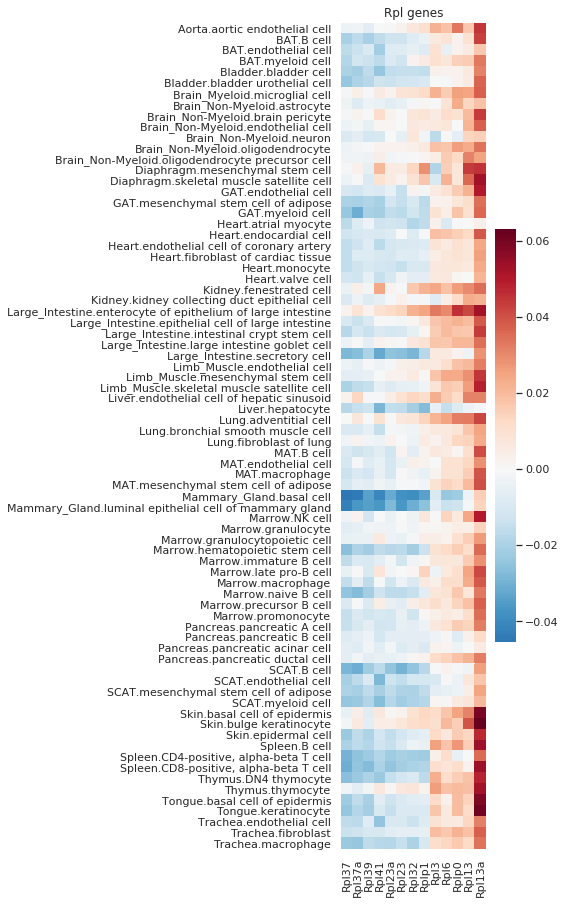

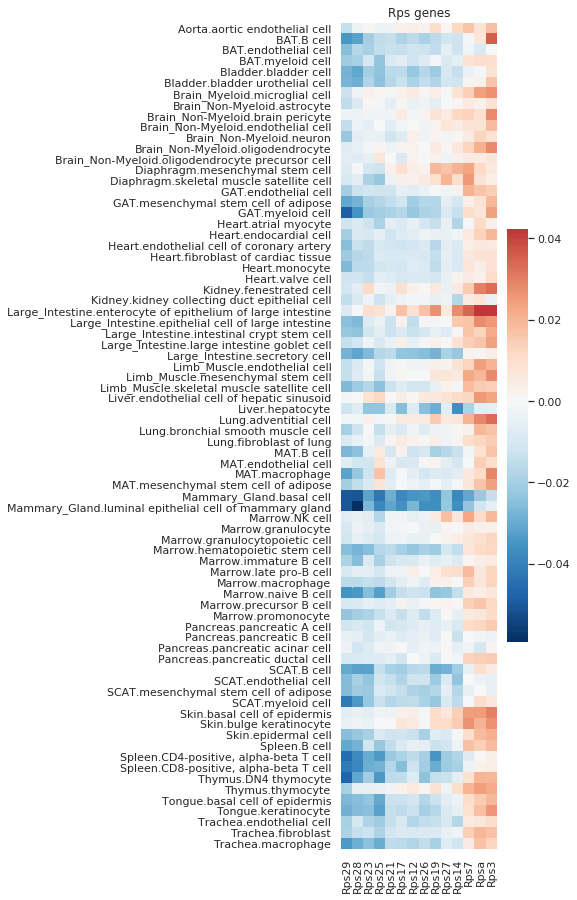

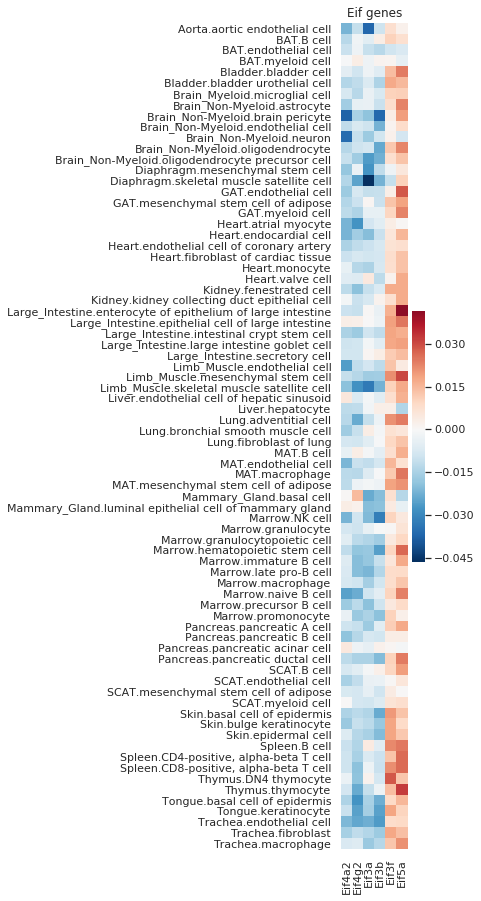

In [40]:
# Rpl and Eif
for gene_prefix in ['Rpl', 'Rps', 'Eif']:
    gene_list = np.array(temp_facs.var_names)
    temp_gene_mask = [x.startswith(gene_prefix) for x in gene_list]
    temp_gene_list = gene_list[temp_gene_mask]
    dic_interesting_gene_list[gene_prefix] = temp_gene_list.copy()
    temp_df = df_global_aging_gene.loc[temp_gene_list].copy()
    gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.5].index
    # temp_gene_list = list(temp_df.index)
    # gene_list_select = temp_df[temp_df['Prop. of Sig.']>0.4].index
    # visualization
    temp_df = df_fc_MAST.loc[gene_list_select]
    temp_df = temp_df.fillna(value=0)
    ind_sort = list(np.argsort(temp_df.median(axis=1)))
    temp_df = temp_df.iloc[ind_sort]
    temp_df = temp_df.T
    # visualization: overview
    plt.figure(figsize = [0.25*temp_df.shape[1], 0.2*temp_df.shape[0]])
    sns.heatmap(temp_df, xticklabels=True, yticklabels=True,
                cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.5})
    plt.title('%s genes'%gene_prefix)
    plt.savefig(output_folder_fig + '/tc_%s_heatmap.pdf'%gene_prefix,
                transparent=True, bbox_inches='tight')
    plt.show()

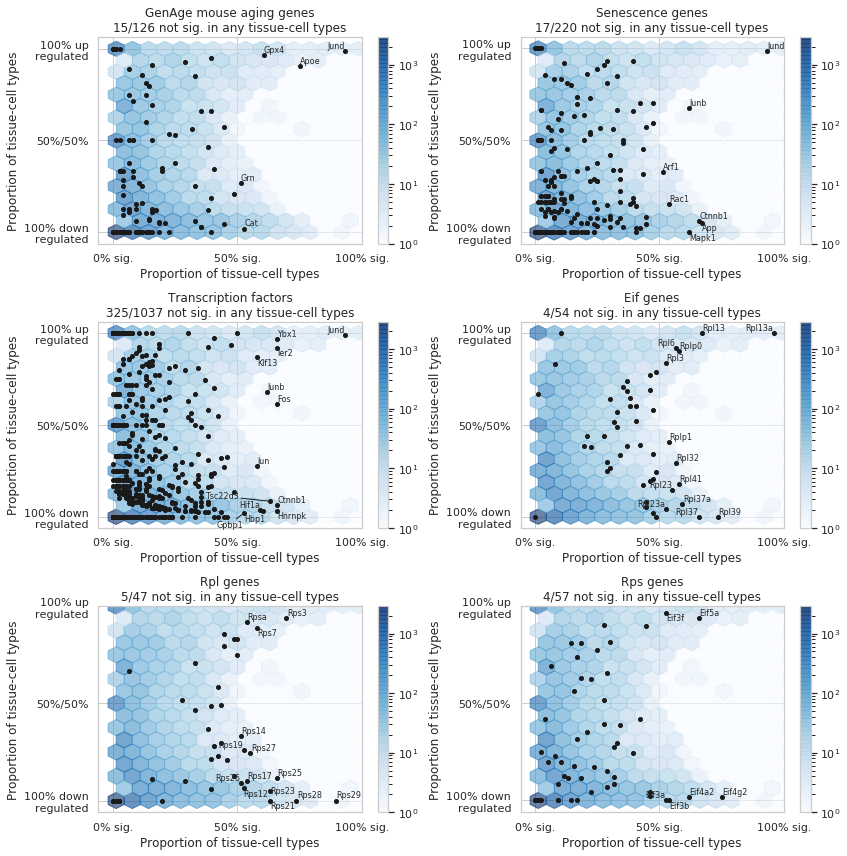

In [41]:
plt.figure(figsize=[12, 12])
title_list = ['GenAge mouse aging genes', 'Senescence genes', 'Transcription factors',
              'Eif genes', 'Rpl genes', 'Rps genes']
term_list = ['AgeGen', 'Senescence', 'TF', 'Eif', 'Rpl', 'Rps']
for i_term,term in enumerate(dic_interesting_gene_list.keys()):
    # corresponding scatter plot
    ind_global = df_global_aging_gene['Prop. of Sig.']>0
    temp_df = df_global_aging_gene.loc[ind_global]
#     plt.figure(figsize=[6,4])
    plt.subplot(3,2,i_term+1)
    plt.hexbin(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], gridsize=15,
               cmap = 'Blues', bins='log', alpha=0.6)
    plt.colorbar()
    
    temp_df = df_global_aging_gene.loc[dic_interesting_gene_list[term]]
    plt.scatter(temp_df['Prop. of Sig.'], temp_df['Prop. of +'], color='k',
                alpha=1, s=16)
    
    # plt.ylabel('Proportion of tissue-cell types \nwhere the gene is up-regulated')
    plt.ylabel('Proportion of tissue-cell types')
    # plt.xlabel('Proportion of tissue-cell types \nwhere the gene has a significant aging effect')
    plt.xlabel('Proportion of tissue-cell types')
    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    
    texts = []
    ind_select = temp_df['Prop. of Sig.']>0.5
    for gene_name in temp_df.index[ind_select]:
        texts.append(plt.text(temp_df.loc[gene_name, 'Prop. of Sig.'],
                              temp_df.loc[gene_name, 'Prop. of +'],
                              gene_name, fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    
    plt.title('%s\n%d/%d not sig. in any tissue-cell types'%(title_list[i_term], 
                           np.sum(temp_df['Prop. of Sig.']==0),
                           temp_df.shape[0]))
    plt.tight_layout()
plt.savefig(output_folder_fig + '/tc_scatter_interesting_genes.pdf',
            transparent=True)
plt.show()
#     break

### Comparison with tissue global genes

In [42]:
# Load the tissue-only data for comparison
with open(DE_result_path+'/DE_tissue_FACS.pickle', 'rb') as handle:
    DE_result_MAST_tissue = pickle.load(handle)
    analysis_list_tissue = pickle.load(handle)
    analysis_info_tissue = pickle.load(handle)
with open(DE_result_path+'/DE_tissue_droplet.pickle', 'rb') as handle:
    DE_result_MAST_tissue_droplet = pickle.load(handle)
    analysis_list_tissue_droplet = pickle.load(handle)
    analysis_info_tissue_droplet = pickle.load(handle)

In [43]:
gene_name_list = list(DE_result_MAST_tissue['BAT'].index)
df_bh_p_MAST_tissue = pd.DataFrame(index = gene_name_list)
df_fc_MAST_tissue = pd.DataFrame(index = gene_name_list)
for analyte in DE_result_MAST_tissue.keys():
    df_bh_p_MAST_tissue[analyte] = DE_result_MAST_tissue[analyte]['bh-p']
    df_fc_MAST_tissue[analyte] = DE_result_MAST_tissue[analyte]['coef']
df_global_aging_gene_tissue = pd.DataFrame(index = gene_name_list)
df_global_aging_gene_tissue['t.Prop. of Sig.'] = ((df_bh_p_MAST_tissue<0.01) & 
                                                (np.absolute(df_fc_MAST_tissue)>coef_threshold)).mean(axis=1)
df_global_aging_gene_tissue['t.Prop. of +'] = (df_fc_MAST_tissue>0).sum(axis=1) /\
                                        ((df_fc_MAST_tissue>0) | (df_fc_MAST_tissue<0)).sum(axis=1) 
df_global_aging_gene_tissue['t.Median fc'] = df_fc_MAST_tissue.median(axis=1)
df_global_aging_gene_tissue['t.Median bh-p'] = df_bh_p_MAST_tissue.median(axis=1)

In [44]:
df_comparison = df_global_aging_gene.copy()
df_comparison = df_comparison.join(df_global_aging_gene_tissue)

In [45]:
n_overlap = np.sum((df_comparison['Prop. of Sig.']>0.5) & 
                   (df_comparison['t.Prop. of Sig.']>0.8))
n_t_only = np.sum(df_comparison['t.Prop. of Sig.']>0.8) - n_overlap
n_tc_only = np.sum(df_comparison['Prop. of Sig.']>0.5) - n_overlap
print('Overlap:%d, tissue:%d, tissue_celltype:%d'%
      (n_overlap, n_t_only, n_tc_only))
# Fisher's exact test
temp_table = np.zeros([2,2], dtype=int)
temp_table[0,0] = temp_facs.shape[1] - n_t_only - n_tc_only - n_overlap
temp_table[0,1] = n_t_only
temp_table[1,0] = n_tc_only
temp_table[1,1] = n_overlap
print(temp_table)
sp.stats.fisher_exact(temp_table, alternative='greater')

Overlap:114, tissue:17, tissue_celltype:178
[[19533    17]
 [  178   114]]


(735.876404494382, 1.0875905209374943e-199)

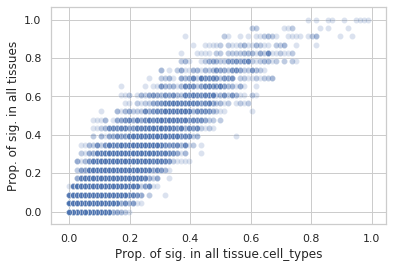

In [46]:
plt.figure()
sns.scatterplot(x='Prop. of Sig.', y='t.Prop. of Sig.', data=df_comparison, alpha=0.2)
plt.ylabel('Prop. of sig. in all tissues')
plt.xlabel('Prop. of sig. in all tissue.cell_types')
plt.show()

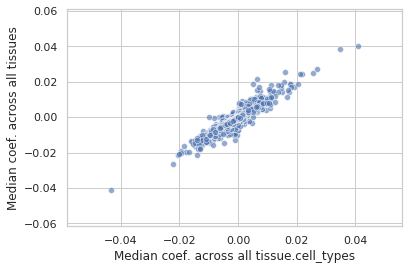

In [47]:
plt.figure()
sns.scatterplot(x='Median fc', y='t.Median fc', data=df_comparison, alpha=0.6)
plt.xlabel('Median coef. across all tissue.cell_types')
plt.ylabel('Median coef. across all tissues')
plt.show()

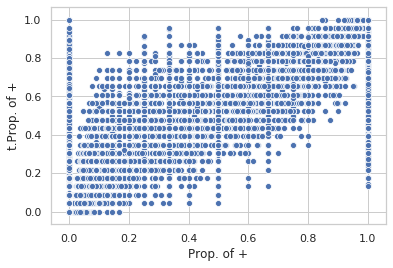

In [48]:
plt.figure()
sns.scatterplot(x='Prop. of +', y='t.Prop. of +', data=df_comparison)
plt.show()

### Aging gene scores of the tissue.cell_types

In [49]:
# compute an aging score: facs
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_facs, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_facs.obs['score'] = temp_facs.obs['score_up'] - temp_facs.obs['score_down']
# compute an aging score: droplet
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['up'], score_name='score_up',
                  random_state=1)
sc.tl.score_genes(temp_droplet, gene_list = dic_global_aging_gene['down'], score_name='score_down',
                  random_state=1)
temp_droplet.obs['score'] = temp_droplet.obs['score_up'] - temp_droplet.obs['score_down']

In [50]:
# Compare with the aging predictor by Peters et al ncomm 2015: load data
# data_folder = '/home/martin/maca/maca-data-analysis/analysis-scripts/data'
df_peter_predictor = pd.read_csv(anno_data_folder+'/peters_ncomm_2015_data5b.csv', sep=',',
                                 index_col=2)
gp = GProfiler(return_dataframe=True)
temp_gene = gp.orth(organism='hsapiens',
                    query=list(set(df_peter_predictor.index)),
                    target='mmusculus')
temp_gene.index = temp_gene['incoming']
df_peter_predictor = df_peter_predictor.join(temp_gene[['name']])
df_peter_predictor = df_peter_predictor.sort_values('order')
df_peter_predictor = df_peter_predictor.drop_duplicates(subset=['name'])
df_peter_predictor.index = df_peter_predictor['name']
df_peter_predictor = df_peter_predictor.loc[df_peter_predictor.index!='N/A']
# only keep genes in temp_facs
temp_gene_list = list(set(temp_facs.var_names) & set(df_peter_predictor.index))
df_peter_predictor = df_peter_predictor.loc[temp_gene_list]

In [51]:
# Compare with the aging predictor by Peters et al ncomm 2015:
# test for overlapping with global aging genes 
# significant ones have 'order'<1498
print('Comparing with global aging genes')
ind_select = df_peter_predictor['order']<1498
gene_list_peter = list(df_peter_predictor.index[ind_select])
temp_global_aging = list(set(dic_global_aging_gene['all']) & set(df_peter_predictor.index))
# Fisher's exact test
temp_table = np.zeros([2,2], dtype=int)
temp_table[0,0] = len(set(df_peter_predictor.index) - set(gene_list_peter) - 
                      set(temp_global_aging))
temp_table[0,1] = len(set(gene_list_peter) - set(temp_global_aging))
temp_table[1,0] = len(set(temp_global_aging) - set(gene_list_peter))
temp_table[1,1] = len(set(temp_global_aging) & set(gene_list_peter))
print(temp_table)
print(sp.stats.fisher_exact(temp_table, alternative='greater'))
# 
for cate in dic_tc_specific_gene.keys():
    if len(dic_tc_specific_gene[cate])<5:
        continue
    print('Comparing with %s-specific genes'%cate)
    temp_global_aging = list(set(dic_tc_specific_gene[cate]) & set(df_peter_predictor.index))
    # Fisher's exact test
    temp_table = np.zeros([2,2], dtype=int)
    temp_table[0,0] = len(set(df_peter_predictor.index) - set(gene_list_peter) - 
                          set(temp_global_aging))
    temp_table[0,1] = len(set(gene_list_peter) - set(temp_global_aging))
    temp_table[1,0] = len(set(temp_global_aging) - set(gene_list_peter))
    temp_table[1,1] = len(set(temp_global_aging) & set(gene_list_peter))
    print(temp_table)
    print(sp.stats.fisher_exact(temp_table, alternative='greater'))

Comparing with global aging genes
[[8582 1294]
 [ 183   34]]
(1.2322024307227135, 0.15740712712690572)
Comparing with immune-specific genes
[[8645 1280]
 [ 120   48]]
(2.7015625, 8.345578263308544e-08)
Comparing with stem cell/progenitor-specific genes
[[8663 1310]
 [ 102   18]]
(1.166995958688819, 0.3120338505133609)
Comparing with endothelial-specific genes
[[8726 1315]
 [  39   13]]
(2.21191381495564, 0.015052261818127266)


In [52]:
import statsmodels.formula.api as sm
# Compare with the aging predictor by Peters et al ncomm 2015:
# Compute an aging score based on the predictor
temp_data = temp_facs[:,temp_gene_list]
# regress out sex as in the receipe (too slow, regress after the aging score instead)
# sc.pp.regress_out(temp_data, 'sex')
temp_coef = np.array(df_peter_predictor.loc[temp_gene_list, 'PREDICTOR-for-NEW-COHORTS'])
temp_peter_age = temp_data.X.dot(temp_coef)
temp_facs.obs['score_peters'] = temp_peter_age
# regress out chronological age and sex and interaction
temp_facs.obs['score_regout_peters'] = 0
temp_df_lr = temp_facs.obs.copy()
result = sm.ols(formula="score_peters ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_facs.obs['score_regout_peters'] = result.resid
print('aging score in Peters et al 2015\n', result.params)
print('')

aging score in Peters et al 2015
 Intercept                 0.174123
age[T.24m]               -0.002437
age[T.3m]                 0.004150
sex[T.male]              -0.024826
age[T.24m]:sex[T.male]   -0.002437
age[T.3m]:sex[T.male]     0.031031
dtype: float64



In [53]:
# get the number of cell types for both facs and droplet
category_list = []
for x in df_cell_category['cell category']:
    category_list += x.split(';')
category_list = list(set(category_list))
category_list.sort()
df_cell_cate_annotation = pd.DataFrame(index=category_list, columns=['n_celltype'], data=0)
for cate in category_list:
    ind_select =  [cate in x for x in df_cell_category['cell category']] 
    df_cell_cate_annotation.loc[cate, 'n_celltype'] = np.sum(ind_select)
# add n_celltype
temp_facs.obs['n_celltype'] = 0
temp_droplet.obs['n_celltype'] = 0
for analyte in analysis_list:
    cate_list = df_cell_category.loc[analyte, 'cell category'].split(';')
    mean_n_celltype = np.mean(df_cell_cate_annotation.loc[cate_list, 'n_celltype'])
    # FACS
    ind_select = temp_facs.obs['analyte']==analyte
    temp_facs.obs.loc[ind_select, 'n_celltype'] = mean_n_celltype
    # Droplet
    ind_select = temp_droplet.obs['analyte']==analyte
    temp_droplet.obs.loc[ind_select, 'n_celltype'] = mean_n_celltype
# ind of cells that are included in the analysis 
ind_analysis = temp_facs.obs['n_celltype']>0
print('FACS', np.sum(ind_analysis)/temp_facs.shape[0])
ind_analysis_droplet = temp_droplet.obs['n_celltype']>0
print('droplet', np.sum(ind_analysis_droplet)/temp_droplet.shape[0])

FACS 0.8249276019678309
droplet 0.41041538298098373


In [54]:
# Regress out sex and age (and n_cell_type)
import statsmodels.formula.api as sm
# facs
temp_facs.obs['score_regout'] = 0
temp_df_lr = temp_facs.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_facs.obs['score_regout'] = result.resid
print('facs\n', result.params)
print('')
# facs: regress out n_celltype
temp_facs.obs['score_regout_n_celltype'] = 0
temp_df_lr = temp_facs.obs.loc[ind_analysis]
result = sm.ols(formula="score ~ age + sex + age*sex + n_celltype", data=temp_df_lr).fit()
temp_facs.obs.loc[ind_analysis, 'score_regout_n_celltype'] = result.resid
print('facs, n_celltype\n', result.params)
print('')
# droplet
temp_droplet.obs['score_regout'] = 0
temp_df_lr = temp_droplet.obs.copy()
result = sm.ols(formula="score ~ age + sex + age*sex", data=temp_df_lr).fit()
temp_droplet.obs['score_regout'] = result.resid
print('droplet\n', result.params)
print('')
# droplet: regress out n_celltype
temp_droplet.obs['score_regout_n_celltype'] = 0
temp_df_lr = temp_droplet.obs.loc[ind_analysis_droplet]
result = sm.ols(formula="score ~ age + sex + age*sex + n_celltype", data=temp_df_lr).fit()
temp_droplet.obs.loc[ind_analysis_droplet, 'score_regout_n_celltype'] = result.resid
print('droplet, n_celltype\n', result.params)
print('')

facs
 Intercept                 0.470175
age[T.24m]                0.032099
age[T.3m]                -0.224041
sex[T.male]               0.073420
age[T.24m]:sex[T.male]    0.032099
age[T.3m]:sex[T.male]    -0.240392
dtype: float64

facs, n_celltype
 Intercept                 0.523340
age[T.24m]                0.032754
age[T.3m]                -0.225451
sex[T.male]               0.080080
age[T.24m]:sex[T.male]    0.032754
age[T.3m]:sex[T.male]    -0.241813
n_celltype               -0.003209
dtype: float64

droplet
 Intercept                 1.639711e-01
age[T.1m]                -1.392438e+06
age[T.21m]                3.366678e-02
age[T.24m]               -8.842006e+09
age[T.30m]               -6.172251e+09
age[T.3m]                -2.360350e-02
sex[T.male]              -1.834895e-03
age[T.1m]:sex[T.male]     1.392438e+06
age[T.21m]:sex[T.male]   -4.028838e-06
age[T.24m]:sex[T.male]    8.842006e+09
age[T.30m]:sex[T.male]    6.172251e+09
age[T.3m]:sex[T.male]    -1.166752e-03
dtype: float

In [55]:
# facs aging score (regress out age and sex)
df_aging_score = temp_facs.obs.groupby(['analyte']).agg({'score_regout':'mean',
                                                         'score_regout_n_celltype':'mean',
                                                         'cell':len,
                                                         'score_regout_peters':'mean'})
df_aging_score = df_aging_score.loc[analysis_list].copy()
df_aging_score = df_aging_score.sort_values(by='score_regout')
df_aging_score['analyte'] = df_aging_score.index
df_aging_score['loc'] = np.arange(df_aging_score.shape[0])
df_aging_score['# of Sig. global aging'] = [np.sum(df_global_aging_gene.loc
                                                   [dic_global_aging_gene['all'], 
                                                    '%s.Sig.'%x])
                                            for x in df_aging_score.index]
df_aging_score = df_aging_score.join(df_analysis[['n_rej']])
df_aging_score = df_aging_score.join(df_cell_category)
# droplet aging score (regress out age and sex)
df_aging_score_droplet = temp_droplet.obs.groupby(['analyte']).agg({'score_regout':'mean',
                                                         'score_regout_n_celltype':'mean',
                                                         'cell':len})
df_aging_score_droplet = df_aging_score_droplet.loc[analysis_list_droplet].copy()
df_aging_score_droplet = df_aging_score_droplet.sort_values(by='score_regout')
df_aging_score_droplet['analyte'] = df_aging_score_droplet.index
df_aging_score_droplet['loc'] = np.arange(df_aging_score_droplet.shape[0])
df_aging_score_droplet = df_aging_score_droplet.join(df_cell_category)

In [56]:
# Visualize the aging score for different cell categories 
category_list = []
for x in df_aging_score['cell category']:
    category_list += x.split(';')
category_list = list(set(category_list))
category_list.remove('muscle cell')
df_aging_score_cate = pd.DataFrame(index=category_list, 
                                   columns = ['mean_score', 'std_score', 
                                              'mean_score_n_cell_type', 
                                              'std_score_n_cell_type',
                                              'n_celltype', 'mean_#_sig_global'],
                                   data=0)
for cate in category_list:
    ind_select =  [cate in x for x in df_aging_score['cell category']]
    temp_list_cell_cate = df_aging_score.index[ind_select]
    df_aging_score_cate.loc[cate, ['mean_score']] = \
        np.mean(df_aging_score['score_regout'][ind_select])
    df_aging_score_cate.loc[cate, ['std_score']] = \
        np.std(df_aging_score['score_regout'][ind_select])/np.sqrt(np.sum(ind_select))
    df_aging_score_cate.loc[cate, ['mean_score_n_cell_type']] = \
        np.mean(df_aging_score['score_regout_n_celltype'][ind_select])
    df_aging_score_cate.loc[cate, ['std_score_n_cell_type']] = \
        np.std(df_aging_score['score_regout_n_celltype'][ind_select])/np.sqrt(np.sum(ind_select))
    df_aging_score_cate.loc[cate, ['n_celltype']] = np.sum(ind_select)
    # 
    df_aging_score_cate.loc[cate, ['mean_#_sig_global']] = \
        np.mean(df_aging_score.loc[ind_select, '# of Sig. global aging'])    
df_aging_score_cate = df_aging_score_cate.sort_values(by='mean_score', ascending=False)
category_list = df_aging_score_cate.index

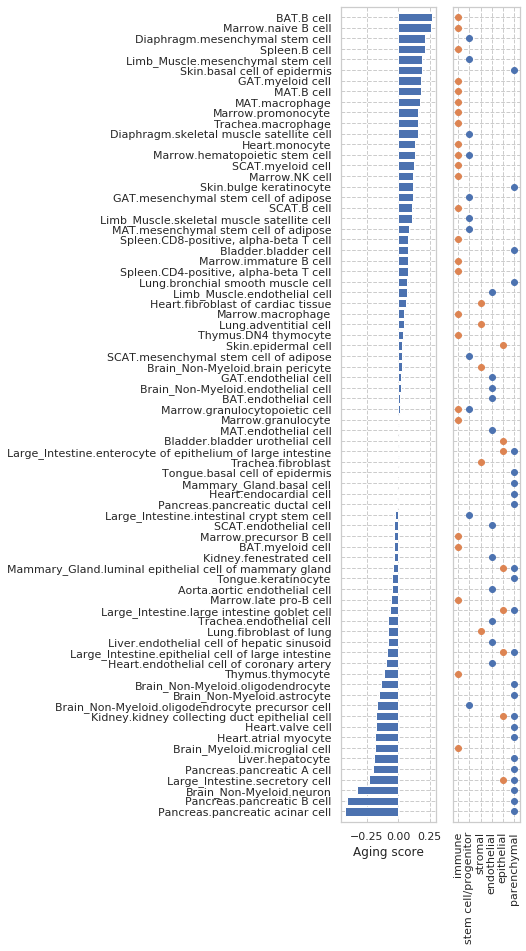

In [57]:
from matplotlib import gridspec
y_min,y_max = -1, df_aging_score.shape[0]
plt.figure(figsize=[3.2,15])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.7]) 
plt.subplot(gs[0])
plt.barh(df_aging_score['loc'], df_aging_score['score_regout'])
plt.ylim([y_min, y_max])
plt.xlabel('Aging score')
plt.yticks(df_aging_score['loc'], df_aging_score['analyte'])
plt.grid(True, linestyle='--')
plt.subplot(gs[1])
for i_cate,cate in enumerate(category_list):
    temp_color = 'C1' if i_cate%2==0 else 'C0'
    ind_select = df_aging_score['cell category']==cate
    ind_select = [cate in x for x in df_aging_score['cell category']]
    plt.scatter([i_cate]*np.sum(ind_select), df_aging_score.loc[ind_select, 'loc'],
                color = temp_color)
plt.xticks(np.arange(len(category_list)), category_list, rotation=90)
plt.ylim([y_min, y_max])
plt.xlim([-0.5, len(category_list)-0.5])
plt.yticks(np.arange(df_aging_score.shape[0]), ['']*df_aging_score.shape[0])
plt.grid(True, linestyle='--')
plt.grid(True, which='major', axis='x')
plt.savefig(output_folder_fig + '/tc_aging_score_FACS.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

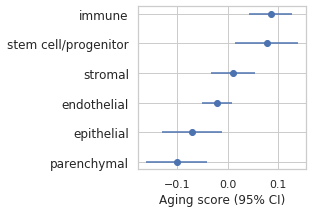

In [58]:
plt.figure(figsize=[3,3])
plt.errorbar(df_aging_score_cate['mean_score'], np.arange(df_aging_score_cate.shape[0])[::-1], 
             xerr=1.96*df_aging_score_cate['std_score'], linestyle='',
             marker='o')
plt.yticks(np.arange(df_aging_score_cate.shape[0])[::-1],
           df_aging_score_cate.index, rotation=0, fontsize=12)
plt.xlabel('Aging score (95% CI)')
plt.savefig(output_folder_fig + '/tc_aging_score_FACS_by_cate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

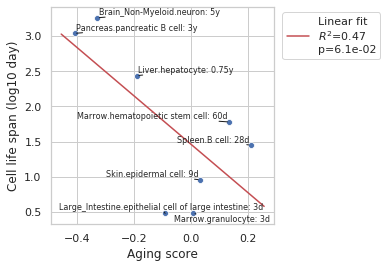

In [59]:
# correlation with cell turnover rate
plt.figure(figsize=[4,4])
temp_df = df_aging_score.loc[df_aging_score['turnover rate in mouse']!=''].copy()
temp_df['turnover rate num'] = [np.log10(float(x[:-1])) if x[-1]=='d' else
                                np.log10(float(x[:-1])*365) 
                                for x in temp_df['turnover rate in mouse']]

sns.scatterplot(data=temp_df, x='score_regout', y='turnover rate num')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(temp_df['score_regout'], 
                                                temp_df['turnover rate num'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend(bbox_to_anchor=[1.5,1])

texts = []
for analyte in temp_df.index:
    texts.append(plt.text(temp_df.loc[analyte, 'score_regout'],
                          temp_df.loc[analyte, 'turnover rate num'],
                          '%s: %s'%(analyte, temp_df.loc[analyte, 'turnover rate in mouse']),
                          fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.ylabel('Cell life span (log10 day)')
plt.xlabel('Aging score')
plt.savefig(output_folder_fig + '/tc_aging_score_turnover_rate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

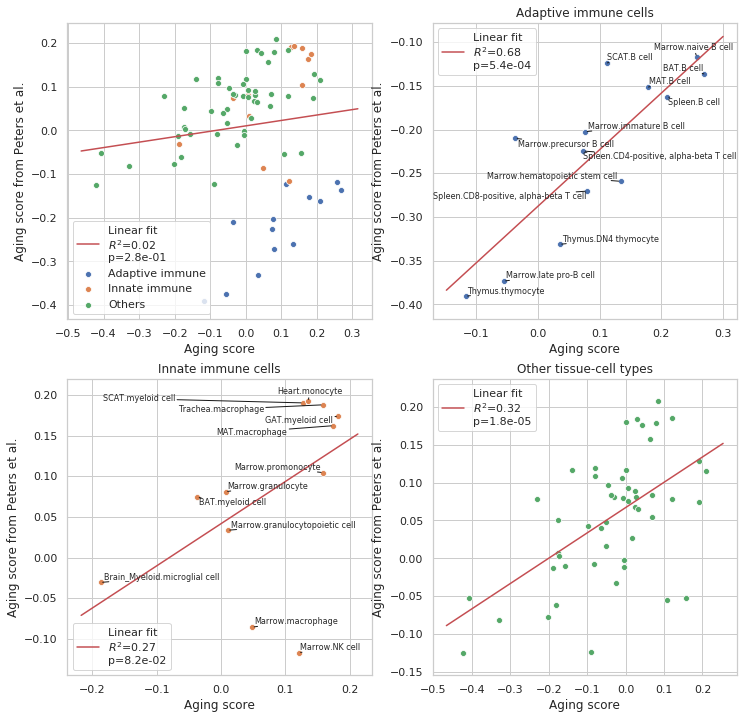

In [60]:
# Comparing with the aging score in Peters et al.
ind_select = ['immune' in x.split(';') for x in df_cell_category['cell category']]
analyte_list = df_cell_category.index[ind_select]
adaptive_immune_list = ['BAT.B cell', 'MAT.B cell', 'Marrow.hematopoietic stem cell',
                        'Marrow.immature B cell', 'Marrow.late pro-B cell',
                        'Marrow.naive B cell', 'Marrow.precursor B cell',
                        'SCAT.B cell', 'Spleen.B cell',
                        'Spleen.CD4-positive, alpha-beta T cell',
                        'Spleen.CD8-positive, alpha-beta T cell',
                        'Thymus.DN4 thymocyte', 'Thymus.thymocyte']
innate_immune_list = list(set(analyte_list) - set(adaptive_immune_list))
rest_list = list(set(df_cell_category.index) - set(analyte_list)
                 - set(adaptive_immune_list))

plt.figure(figsize=[12,12])
plt.subplot(221)
sns.scatterplot(data=df_aging_score.loc[adaptive_immune_list],
                x='score_regout', y='score_regout_peters', label='Adaptive immune', color='C0')
sns.scatterplot(data=df_aging_score.loc[innate_immune_list],
                x='score_regout', y='score_regout_peters', label='Innate immune', color='C1')
sns.scatterplot(data=df_aging_score.loc[rest_list],
                x='score_regout', y='score_regout_peters', label='Others', color='C2')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')

plt.subplot(222)
sns.scatterplot(data=df_aging_score.loc[adaptive_immune_list],
                x='score_regout', y='score_regout_peters', color='C0')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[adaptive_immune_list, 'score_regout'], 
                                                df_aging_score.loc[adaptive_immune_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Adaptive immune cells')

texts = []
for analyte in adaptive_immune_list:
    texts.append(plt.text(df_aging_score.loc[analyte, 'score_regout'],
                          df_aging_score.loc[analyte, 'score_regout_peters'],
                          '%s'%(analyte), fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.subplot(223)
sns.scatterplot(data=df_aging_score.loc[innate_immune_list],
                x='score_regout', y='score_regout_peters', color='C1')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[innate_immune_list, 'score_regout'], 
                                                df_aging_score.loc[innate_immune_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend(loc='lower left')
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Innate immune cells')

texts = []
for analyte in innate_immune_list:
    texts.append(plt.text(df_aging_score.loc[analyte, 'score_regout'],
                          df_aging_score.loc[analyte, 'score_regout_peters'],
                          '%s'%(analyte), fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

plt.subplot(224)
sns.scatterplot(data=df_aging_score.loc[rest_list],
                x='score_regout', y='score_regout_peters', color='C2')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score.loc[rest_list, 'score_regout'], 
                                                df_aging_score.loc[rest_list, 'score_regout_peters'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Aging score from Peters et al.')
plt.title('Other tissue-cell types')

plt.savefig(output_folder_fig + '/tc_aging_score_peter.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

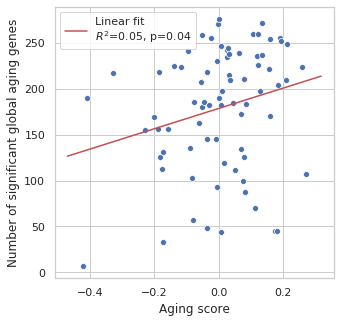

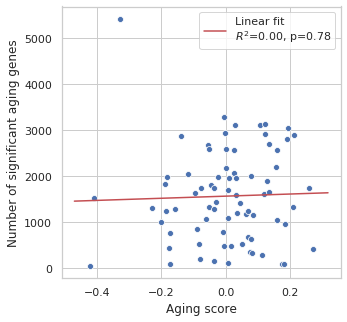

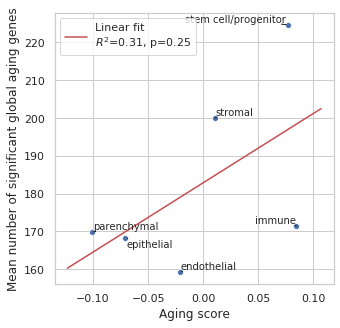

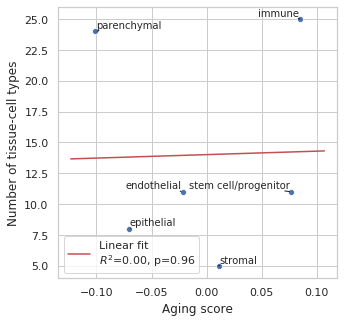

In [66]:
# Confounding factors
# # of significant global aging gene v.s. aging score
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score, x='score_regout', y='# of Sig. global aging')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['# of Sig. global aging'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Number of significant global aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_mean_#_sig_global.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

# # of significant global aging gene v.s. aging score
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score, x='score_regout', y='n_rej')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score['score_regout'], 
                                                df_aging_score['n_rej'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
plt.xlabel('Aging score')
plt.ylabel('Number of significant aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_n_rej.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score_cate, x='mean_score', y='mean_#_sig_global')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score_cate['mean_score'], 
                                                df_aging_score_cate['mean_#_sig_global'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
# annotation
texts = []
for cell_cate in df_aging_score_cate.index:
    texts.append(plt.text(df_aging_score_cate.loc[cell_cate, 'mean_score'],
                          df_aging_score_cate.loc[cell_cate, 'mean_#_sig_global'],
                          cell_cate, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.xlabel('Aging score')
plt.ylabel('Mean number of significant global aging genes')
plt.savefig(output_folder_fig + '/tc_aging_score_by_mean_#_sig_global_cell_cate.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

# 
plt.figure(figsize=[5,5])
sns.scatterplot(data=df_aging_score_cate, x='mean_score', y='n_celltype')
# linear fit
sl, icpt, r_val, p_val, _ = sp.stats.linregress(df_aging_score_cate['mean_score'], 
                                                df_aging_score_cate['n_celltype'])
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
         label='Linear fit\n$R^2$=%0.2f, p=%0.2f'%(r_val**2, p_val))
plt.legend()
# annotation
texts = []
for cell_cate in df_aging_score_cate.index:
    texts.append(plt.text(df_aging_score_cate.loc[cell_cate, 'mean_score'],
                          df_aging_score_cate.loc[cell_cate, 'n_celltype'],
                          cell_cate, fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
plt.xlabel('Aging score')
plt.ylabel('Number of tissue-cell types')
plt.savefig(output_folder_fig + '/tc_aging_score_by_n_celltype.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [62]:
# Comparison between the two technologies: reimplement
analyte_list = list(set(df_aging_score['analyte']) | set(df_aging_score_droplet['analyte']))
temp_comparison = pd.DataFrame(index = analyte_list)
method_list = ['FACS', 'droplet']
for method in method_list:
    temp_comparison['score_regout.%s'%(method)] = -1
    temp_comparison['n_cell.%s'%(method)] = -1
for analyte in temp_comparison.index:
    # FACS
    ind_select = (temp_facs.obs['analyte']==analyte)
    if np.sum(ind_select)>0:
        temp_comparison.loc[analyte, 'score_regout.FACS'] = \
            np.mean(temp_facs.obs['score_regout'][ind_select])
        temp_comparison.loc[analyte, 'n_cell.FACS'] = \
            np.sum(ind_select)
    # droplet
    ind_select = (temp_droplet.obs['analyte']==analyte)
    if np.sum(ind_select)>0:
        temp_comparison.loc[analyte, 'score_regout.droplet'] = \
            np.mean(temp_droplet.obs['score_regout'][ind_select])
        temp_comparison.loc[analyte, 'n_cell.droplet'] = \
            np.sum((temp_droplet.obs['analyte']==analyte))
temp_comparison = temp_comparison.loc[(temp_comparison!=-1).sum(axis=1)>0]
ind_select = np.array(['nan' not in x for x in temp_comparison.index])
temp_comparison = temp_comparison.loc[ind_select]

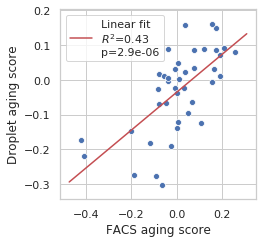

In [63]:
comparison_list = ['FACS;droplet']
for comparison in comparison_list:
    method1,method2 = comparison.split(';')
    ind_select = (temp_comparison[['score_regout.%s'%(method1),
                                   'score_regout.%s'%(method2)]]==-1).sum(axis=1)==0
    plt.figure(figsize=[3.5,3.5])
    sns.scatterplot(x='score_regout.%s'%(method1), y='score_regout.%s'%(method2),
                    data=temp_comparison.loc[ind_select])
    x_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method1)],
                     dtype=float)
    y_val = np.array(temp_comparison.loc[ind_select, 'score_regout.%s'%(method2)],
                     dtype=float)                                 
    sl, icpt, r_val, p_val, _ = sp.stats.linregress(x_val, y_val)
    # linear fit
    x_min,x_max = plt.xlim()
    y_min,y_max = plt.ylim()
    plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
             label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
    plt.legend()
    plt.xlabel('FACS aging score')
    plt.ylabel('Droplet aging score')
#     texts = []
#     for tissue in temp_comparison.index[ind_select]:
#         if ((temp_comparison.loc[tissue, 'score_regout.FACS']<-0.2) & 
#             (temp_comparison.loc[tissue, 'score_regout.droplet']<-0.2)) | \
#             ((temp_comparison.loc[tissue, 'score_regout.FACS']>0.2) & 
#             (temp_comparison.loc[tissue, 'score_regout.droplet']>0)):
#             texts.append(plt.text(temp_comparison.loc[tissue, 'score_regout.%s'%(method1)],
#                                   temp_comparison.loc[tissue, 'score_regout.%s'%(method2)],
#                                   tissue, fontsize=8))
#     adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))
    plt.savefig(output_folder_fig + '/tc_aging_score_%s_%s.pdf'%(method1, method2),
                transparent=True, bbox_inches='tight')
    plt.show()